In [2]:
pip install pm4py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.2 MB/s eta 0:00:00


In [3]:
import pm4py
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.inspection import permutation_importance

import gradio as gr

**Loading Data**

In [4]:
log = pm4py.read_xes('//content/BPI Challenge 2017 - Offer log.xes.gz')

/usr/local/lib/python3.12/dist-packages/pm4py/utils.py:1000: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/42995 [00:00<?, ?it/s]

In [5]:
df = pm4py.convert_to_dataframe(log)

**Viewing the data**

In [6]:
df.head(50)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
0,Created,User_17,O_Create Offer,Offer,Offer_247135719,complete,2016-01-02 09:17:05.720000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,NaN
1,statechange,User_17,O_Created,Offer,OfferState_124849367,complete,2016-01-02 09:17:08.762000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
2,statechange,User_17,O_Sent (online only),Offer,OfferState_440662877,complete,2016-01-02 09:19:21.330000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
3,statechange,User_17,O_Cancelled,Offer,OfferState_591416028,complete,2016-01-02 09:21:26.034000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
4,Created,User_17,O_Create Offer,Offer,Offer_941964966,complete,2016-01-02 09:21:42.022000+00:00,Offer_941964966,201.76,False,Application_196483749,4100.0,0,10000.0,57,True,NaN
5,statechange,User_17,O_Created,Offer,OfferState_275382868,complete,2016-01-02 09:21:43.573000+00:00,Offer_941964966,201.76,False,Application_196483749,4100.0,0,10000.0,57,True,Offer_941964966
6,statechange,User_17,O_Sent (mail and online),Offer,OfferState_563158836,complete,2016-01-02 09:22:09.421000+00:00,Offer_941964966,201.76,False,Application_196483749,4100.0,0,10000.0,57,True,Offer_941964966
7,statechange,User_1,O_Cancelled,Offer,OfferState_293765867,complete,2016-02-29 07:01:05.256000+00:00,Offer_941964966,201.76,False,Application_196483749,4100.0,0,10000.0,57,True,Offer_941964966
8,Created,User_17,O_Create Offer,Offer,Offer_1148420274,complete,2016-01-02 09:26:43.598000+00:00,Offer_1148420274,120.00,False,Application_196483749,0.0,0,6000.0,58,True,NaN
9,statechange,User_17,O_Created,Offer,OfferState_1323744692,complete,2016-01-02 09:26:44.925000+00:00,Offer_1148420274,120.00,False,Application_196483749,0.0,0,6000.0,58,True,Offer_1148420274


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193849 entries, 0 to 193848
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   Action                      193849 non-null  object             
 1   org:resource                193849 non-null  object             
 2   concept:name                193849 non-null  object             
 3   EventOrigin                 193849 non-null  object             
 4   EventID                     193849 non-null  object             
 5   lifecycle:transition        193849 non-null  object             
 6   time:timestamp              193849 non-null  datetime64[ns, UTC]
 7   case:concept:name           193849 non-null  object             
 8   case:MonthlyCost            193849 non-null  float64            
 9   case:Selected               193849 non-null  bool               
 10  case:ApplicationID          193849 non-null 

**Checking missing values**

In [8]:
df.isnull().sum().sort_values(ascending=False)

,0
OfferID,42995
Action,0
org:resource,0
EventOrigin,0
concept:name,0
lifecycle:transition,0
time:timestamp,0
case:concept:name,0
EventID,0
case:MonthlyCost,0


**Data Understanding**

In [9]:
df[df['case:concept:name'] == 'Offer_247135719']

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
0,Created,User_17,O_Create Offer,Offer,Offer_247135719,complete,2016-01-02 09:17:05.720000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,NaN
1,statechange,User_17,O_Created,Offer,OfferState_124849367,complete,2016-01-02 09:17:08.762000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
2,statechange,User_17,O_Sent (online only),Offer,OfferState_440662877,complete,2016-01-02 09:19:21.330000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
3,statechange,User_17,O_Cancelled,Offer,OfferState_591416028,complete,2016-01-02 09:21:26.034000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719


In [10]:
df[df['case:ApplicationID'] == 'Application_196483749'].nunique()

,0
Action,2
org:resource,3
concept:name,5
EventOrigin,1
EventID,16
lifecycle:transition,1
time:timestamp,16
case:concept:name,4
case:MonthlyCost,3
case:Selected,1


In [11]:
df[df['case:concept:name'] == 'Offer_1365106765']

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
12,Created,User_17,O_Create Offer,Offer,Offer_1365106765,complete,2016-01-02 09:55:46.369000+00:00,Offer_1365106765,150.73,True,Application_1120819670,6900.0,1021,6900.0,53,True,NaN
13,statechange,User_17,O_Created,Offer,OfferState_1700055433,complete,2016-01-02 09:55:47.693000+00:00,Offer_1365106765,150.73,True,Application_1120819670,6900.0,1021,6900.0,53,True,Offer_1365106765
14,statechange,User_17,O_Sent (mail and online),Offer,OfferState_16123997,complete,2016-01-02 09:59:50.268000+00:00,Offer_1365106765,150.73,True,Application_1120819670,6900.0,1021,6900.0,53,True,Offer_1365106765
15,statechange,User_116,O_Returned,Offer,OfferState_608790984,complete,2016-01-08 10:00:24.474000+00:00,Offer_1365106765,150.73,True,Application_1120819670,6900.0,1021,6900.0,53,True,Offer_1365106765
16,statechange,User_95,O_Accepted,Offer,OfferState_1067718689,complete,2016-01-11 09:42:07.001000+00:00,Offer_1365106765,150.73,True,Application_1120819670,6900.0,1021,6900.0,53,True,Offer_1365106765


In [12]:
df[df['case:concept:name'] == 'Offer_1669071500']

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
26,Created,User_38,O_Create Offer,Offer,Offer_1669071500,complete,2016-01-02 11:02:38.994000+00:00,Offer_1669071500,200.0,False,Application_1691306052,500.0,0,6000.0,33,False,NaN
27,statechange,User_38,O_Created,Offer,OfferState_680973097,complete,2016-01-02 11:02:40.442000+00:00,Offer_1669071500,200.0,False,Application_1691306052,500.0,0,6000.0,33,False,Offer_1669071500
28,statechange,User_38,O_Sent (mail and online),Offer,OfferState_618588716,complete,2016-01-02 11:03:05.300000+00:00,Offer_1669071500,200.0,False,Application_1691306052,500.0,0,6000.0,33,False,Offer_1669071500
29,statechange,User_68,O_Refused,Offer,OfferState_1494429296,complete,2016-01-07 13:29:49.710000+00:00,Offer_1669071500,200.0,False,Application_1691306052,500.0,0,6000.0,33,False,Offer_1669071500


In [13]:
df[
    (df['concept:name'] == 'O_Refused') &
    (df['case:Accepted'] == True)
]

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
78,statechange,User_99,O_Refused,Offer,OfferState_722957562,complete,2016-01-11 09:30:52.996000+00:00,Offer_117620760,211.90,True,Application_1878239836,328.0,0,15000.0,84,True,Offer_117620760
160,statechange,User_90,O_Refused,Offer,OfferState_295786467,complete,2016-01-11 09:39:35.166000+00:00,Offer_603196958,284.00,True,Application_546206358,6000.0,0,14200.0,57,True,Offer_603196958
207,statechange,User_75,O_Refused,Offer,OfferState_1464020364,complete,2016-01-12 11:00:35.427000+00:00,Offer_1713418619,241.29,False,Application_1300843234,3500.0,0,12500.0,60,True,Offer_1713418619
216,statechange,User_75,O_Refused,Offer,OfferState_2043153081,complete,2016-01-12 11:00:35.418000+00:00,Offer_207015621,330.34,True,Application_1300843234,3500.0,0,12500.0,42,True,Offer_207015621
398,statechange,User_100,O_Refused,Offer,OfferState_2017952705,complete,2016-01-14 15:16:16.671000+00:00,Offer_1569511625,200.00,False,Application_1193723578,0.0,0,20000.0,127,True,Offer_1569511625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193366,statechange,User_87,O_Refused,Offer,OfferState_74844455,complete,2017-01-13 09:42:56.712000+00:00,Offer_281960456,509.11,False,Application_1782240690,50000.0,0,50000.0,120,True,Offer_281960456
193417,statechange,User_109,O_Refused,Offer,OfferState_1339558180,complete,2017-01-26 12:48:22.895000+00:00,Offer_238242917,189.08,True,Application_398145910,7134.0,0,10000.0,60,True,Offer_238242917
193452,statechange,User_90,O_Refused,Offer,OfferState_31674471,complete,2017-01-13 14:01:02.147000+00:00,Offer_1412107433,198.67,False,Application_442169489,6500.0,0,6500.0,36,True,Offer_1412107433
193506,statechange,User_40,O_Refused,Offer,OfferState_2130246763,complete,2017-01-20 10:40:55.641000+00:00,Offer_2081803363,236.31,False,Application_267160125,6276.0,0,23000.0,120,True,Offer_2081803363


In [14]:
df[df['case:concept:name'] == 'Offer_117620760']

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
74,Created,User_3,O_Create Offer,Offer,Offer_117620760,complete,2016-01-02 13:59:59.998000+00:00,Offer_117620760,211.9,True,Application_1878239836,328.0,0,15000.0,84,True,NaN
75,statechange,User_3,O_Created,Offer,OfferState_1078624957,complete,2016-01-02 14:00:01.362000+00:00,Offer_117620760,211.9,True,Application_1878239836,328.0,0,15000.0,84,True,Offer_117620760
76,statechange,User_3,O_Sent (mail and online),Offer,OfferState_1280164227,complete,2016-01-02 14:00:19.890000+00:00,Offer_117620760,211.9,True,Application_1878239836,328.0,0,15000.0,84,True,Offer_117620760
77,statechange,User_113,O_Returned,Offer,OfferState_789899351,complete,2016-01-08 10:09:09.540000+00:00,Offer_117620760,211.9,True,Application_1878239836,328.0,0,15000.0,84,True,Offer_117620760
78,statechange,User_99,O_Refused,Offer,OfferState_722957562,complete,2016-01-11 09:30:52.996000+00:00,Offer_117620760,211.9,True,Application_1878239836,328.0,0,15000.0,84,True,Offer_117620760


In [15]:
df.groupby('case:ApplicationID')['case:concept:name'].nunique()

,case:concept:name
case:ApplicationID,
Application_1000086665,1
Application_1000158214,1
Application_1000311556,1
Application_1000334415,1
Application_1000339879,1
...,...
Application_999507989,1
Application_999544538,5
Application_999632431,1


In [16]:
df.groupby('case:ApplicationID')['case:concept:name'].nunique().loc[lambda x: x >= 2]

,case:concept:name
case:ApplicationID,
Application_1000671285,2
Application_1000691650,4
Application_1001114274,5
Application_1002485344,2
Application_1002626536,2
...,...
Application_999352398,2
Application_99940018,5
Application_999464866,4


In [17]:
df.groupby('case:ApplicationID')['case:concept:name'].nunique().loc[lambda x: x > 5]

,case:concept:name
case:ApplicationID,
Application_1005568510,8
Application_1009342776,7
Application_1079946708,6
Application_1123655418,7
Application_1142548986,7
...,...
Application_751800085,6
Application_767475240,6
Application_783041368,8


In [18]:
df.groupby('case:ApplicationID')['case:concept:name'].nunique().max()

10

In [19]:
df[df['case:ApplicationID'] == 'Application_999544538']['case:concept:name'].unique()

array(['Offer_468994586', 'Offer_1049656148', 'Offer_1712780407',
       'Offer_984993544', 'Offer_610539704'], dtype=object)

In [20]:
df[df['case:concept:name'] == 'Offer_468994586']

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
58272,Created,User_27,O_Create Offer,Offer,Offer_468994586,complete,2016-05-07 13:56:49.523000+00:00,Offer_468994586,522.97,False,Application_999544538,0.0,0,50000.0,120,True,NaN
58273,statechange,User_27,O_Created,Offer,OfferState_1139270406,complete,2016-05-07 13:56:50.743000+00:00,Offer_468994586,522.97,False,Application_999544538,0.0,0,50000.0,120,True,Offer_468994586
58274,statechange,User_27,O_Sent (mail and online),Offer,OfferState_823393114,complete,2016-05-07 13:57:06.801000+00:00,Offer_468994586,522.97,False,Application_999544538,0.0,0,50000.0,120,True,Offer_468994586
58275,statechange,User_95,O_Cancelled,Offer,OfferState_2027428098,complete,2016-07-26 06:35:18.221000+00:00,Offer_468994586,522.97,False,Application_999544538,0.0,0,50000.0,120,True,Offer_468994586


In [21]:
df[df['case:concept:name'] == 'Offer_1049656148']

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
58316,Created,User_32,O_Create Offer,Offer,Offer_1049656148,complete,2016-05-07 15:04:39.641000+00:00,Offer_1049656148,500.0,False,Application_999544538,0.0,0,50000.0,126,True,NaN
58317,statechange,User_32,O_Created,Offer,OfferState_1138310639,complete,2016-05-07 15:04:40.961000+00:00,Offer_1049656148,500.0,False,Application_999544538,0.0,0,50000.0,126,True,Offer_1049656148
58318,statechange,User_32,O_Sent (mail and online),Offer,OfferState_813963722,complete,2016-05-07 15:04:52.160000+00:00,Offer_1049656148,500.0,False,Application_999544538,0.0,0,50000.0,126,True,Offer_1049656148
58319,statechange,User_95,O_Cancelled,Offer,OfferState_1935003346,complete,2016-07-26 06:35:18.212000+00:00,Offer_1049656148,500.0,False,Application_999544538,0.0,0,50000.0,126,True,Offer_1049656148


In [22]:
df[df['case:concept:name'] == 'Offer_1712780407']

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
67251,Created,User_5,O_Create Offer,Offer,Offer_1712780407,complete,2016-05-28 13:22:53.187000+00:00,Offer_1712780407,509.11,False,Application_999544538,0.0,0,50000.0,120,True,NaN
67252,statechange,User_5,O_Created,Offer,OfferState_1174074276,complete,2016-05-28 13:22:54.676000+00:00,Offer_1712780407,509.11,False,Application_999544538,0.0,0,50000.0,120,True,Offer_1712780407
67253,statechange,User_5,O_Sent (mail and online),Offer,OfferState_771820304,complete,2016-05-28 13:23:05.191000+00:00,Offer_1712780407,509.11,False,Application_999544538,0.0,0,50000.0,120,True,Offer_1712780407
67254,statechange,User_117,O_Returned,Offer,OfferState_97195231,complete,2016-06-21 08:52:28.159000+00:00,Offer_1712780407,509.11,False,Application_999544538,0.0,0,50000.0,120,True,Offer_1712780407
67255,statechange,User_95,O_Cancelled,Offer,OfferState_1686326009,complete,2016-07-26 06:35:18.203000+00:00,Offer_1712780407,509.11,False,Application_999544538,0.0,0,50000.0,120,True,Offer_1712780407


In [23]:
df[df['case:concept:name'] == 'Offer_984993544']

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
83685,Created,User_19,O_Create Offer,Offer,Offer_984993544,complete,2016-06-24 15:54:03.372000+00:00,Offer_984993544,509.11,False,Application_999544538,0.0,0,50000.0,120,True,NaN
83686,statechange,User_19,O_Created,Offer,OfferState_964719972,complete,2016-06-24 15:54:05.063000+00:00,Offer_984993544,509.11,False,Application_999544538,0.0,0,50000.0,120,True,Offer_984993544
83687,statechange,User_19,O_Sent (online only),Offer,OfferState_1702060008,complete,2016-06-24 15:54:20.457000+00:00,Offer_984993544,509.11,False,Application_999544538,0.0,0,50000.0,120,True,Offer_984993544
83688,statechange,User_95,O_Cancelled,Offer,OfferState_1184590673,complete,2016-07-26 06:35:18.194000+00:00,Offer_984993544,509.11,False,Application_999544538,0.0,0,50000.0,120,True,Offer_984993544


In [24]:
df[df['case:concept:name'] == 'Offer_610539704']

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
84297,Created,User_19,O_Create Offer,Offer,Offer_610539704,complete,2016-06-27 08:42:41.810000+00:00,Offer_610539704,509.11,True,Application_999544538,0.0,795,50000.0,120,True,NaN
84298,statechange,User_19,O_Created,Offer,OfferState_613533673,complete,2016-06-27 08:42:43.424000+00:00,Offer_610539704,509.11,True,Application_999544538,0.0,795,50000.0,120,True,Offer_610539704
84299,statechange,User_19,O_Sent (mail and online),Offer,OfferState_1282768200,complete,2016-06-27 08:43:03.641000+00:00,Offer_610539704,509.11,True,Application_999544538,0.0,795,50000.0,120,True,Offer_610539704
84300,statechange,User_122,O_Returned,Offer,OfferState_1642750471,complete,2016-07-08 09:09:48.154000+00:00,Offer_610539704,509.11,True,Application_999544538,0.0,795,50000.0,120,True,Offer_610539704
84301,statechange,User_95,O_Accepted,Offer,OfferState_1003561100,complete,2016-07-26 06:35:18.176000+00:00,Offer_610539704,509.11,True,Application_999544538,0.0,795,50000.0,120,True,Offer_610539704


# IMPORTANT

An application has **one single offer** with `Selected = True` — and that is almost always the one marked as `O_Accepted` in `concept:name`.

## What does Selected mean?

- `True` → the offer is the **final** one
- `False` → the offer is just an **alternative**

## What about case:Accepted?

Every offer that passes the eligibility stage gets `case:Accepted = True` — but that doesn't mean it "won". Only **one** offer is truly accepted in the end. The others can still end up cancelled, returned or rejected, simply because another offer was chosen over them.

In [25]:
df[df['case:ApplicationID'] == 'Application_999993467']['case:concept:name'].unique()

array(['Offer_1512420329', 'Offer_148382244'], dtype=object)

In [26]:
df[df['case:concept:name'] == 'Offer_1512420329']

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
92348,Created,User_49,O_Create Offer,Offer,Offer_1512420329,complete,2016-07-07 13:09:22.265000+00:00,Offer_1512420329,100.0,False,Application_999993467,0.0,0,10000.0,134,False,NaN
92349,statechange,User_49,O_Created,Offer,OfferState_64562475,complete,2016-07-07 13:09:23.944000+00:00,Offer_1512420329,100.0,False,Application_999993467,0.0,0,10000.0,134,False,Offer_1512420329
92350,statechange,User_49,O_Sent (online only),Offer,OfferState_279573828,complete,2016-07-07 13:09:38.730000+00:00,Offer_1512420329,100.0,False,Application_999993467,0.0,0,10000.0,134,False,Offer_1512420329
92351,statechange,User_30,O_Cancelled,Offer,OfferState_1739701115,complete,2016-07-19 11:03:45.140000+00:00,Offer_1512420329,100.0,False,Application_999993467,0.0,0,10000.0,134,False,Offer_1512420329


In [27]:
df[df['case:concept:name'] == 'Offer_148382244']

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
92547,Created,User_15,O_Create Offer,Offer,Offer_148382244,complete,2016-07-07 15:32:11.395000+00:00,Offer_148382244,250.0,True,Application_999993467,0.0,854,15000.0,69,False,NaN
92548,statechange,User_15,O_Created,Offer,OfferState_1422470717,complete,2016-07-07 15:32:13.268000+00:00,Offer_148382244,250.0,True,Application_999993467,0.0,854,15000.0,69,False,Offer_148382244
92549,statechange,User_15,O_Sent (mail and online),Offer,OfferState_474648362,complete,2016-07-07 15:32:24.853000+00:00,Offer_148382244,250.0,True,Application_999993467,0.0,854,15000.0,69,False,Offer_148382244
92550,statechange,User_116,O_Returned,Offer,OfferState_1626579845,complete,2016-07-13 14:30:00.134000+00:00,Offer_148382244,250.0,True,Application_999993467,0.0,854,15000.0,69,False,Offer_148382244
92551,statechange,User_30,O_Accepted,Offer,OfferState_505505592,complete,2016-07-19 11:03:45.111000+00:00,Offer_148382244,250.0,True,Application_999993467,0.0,854,15000.0,69,False,Offer_148382244


*I check if there is any accepted offer that has case:Accepted = False*

In [28]:
df[
    (df['concept:name'] =='O_Accepted')&
    (df['case:Accepted'] == False)
]

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
59,statechange,User_87,O_Accepted,Offer,OfferState_1128437541,complete,2016-01-12 12:13:45.145000+00:00,Offer_1236377933,150.00,True,Application_493034835,1500.00,0,9000.0,72,False,Offer_1236377933
204,statechange,User_95,O_Accepted,Offer,OfferState_1856846652,complete,2016-01-11 10:34:36.587000+00:00,Offer_1026878545,200.00,True,Application_1962860870,590.00,871,6000.0,33,False,Offer_1026878545
235,statechange,User_99,O_Accepted,Offer,OfferState_1845058149,complete,2016-01-27 13:48:32.037000+00:00,Offer_1959589862,100.00,True,Application_1999238509,4000.00,0,10000.0,134,False,Offer_1959589862
245,statechange,User_30,O_Accepted,Offer,OfferState_202935253,complete,2016-01-11 10:35:23.639000+00:00,Offer_1647711220,200.00,True,Application_842511489,0.00,859,15000.0,89,False,Offer_1647711220
273,statechange,User_115,O_Accepted,Offer,OfferState_181573803,complete,2016-01-12 10:55:29.363000+00:00,Offer_818647679,250.00,True,Application_1699757505,6000.00,1030,10000.0,45,False,Offer_818647679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193742,statechange,User_83,O_Accepted,Offer,OfferState_1924637326,complete,2017-01-27 09:40:30.572000+00:00,Offer_1347459317,86.00,True,Application_1917923627,0.00,947,7000.0,104,False,Offer_1347459317
193747,statechange,User_106,O_Accepted,Offer,OfferState_866274764,complete,2017-01-26 08:38:28.033000+00:00,Offer_649388006,87.83,True,Application_367518257,1636.00,828,7800.0,120,False,Offer_649388006
193755,statechange,User_83,O_Accepted,Offer,OfferState_388315184,complete,2017-01-27 08:13:19.269000+00:00,Offer_76120796,238.65,True,Application_28309282,58.77,947,32000.0,180,False,Offer_76120796
193777,statechange,User_75,O_Accepted,Offer,OfferState_2122783290,complete,2017-01-31 16:25:51.996000+00:00,Offer_1326975316,133.07,True,Application_637658579,12500.00,738,12500.0,120,False,Offer_1326975316


In [29]:
df['case:Selected'].unique()

array([False,  True])

In [30]:
df['case:Accepted'].unique()

array([ True, False])

In [31]:
df['EventOrigin'].unique()

array(['Offer'], dtype=object)

In [32]:
df['concept:name'].unique()

array(['O_Create Offer', 'O_Created', 'O_Sent (online only)',
       'O_Cancelled', 'O_Sent (mail and online)', 'O_Returned',
       'O_Accepted', 'O_Refused'], dtype=object)

**EDA**

In [33]:
df.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:concept:name,case:MonthlyCost,case:Selected,case:ApplicationID,case:FirstWithdrawalAmount,case:CreditScore,case:OfferedAmount,case:NumberOfTerms,case:Accepted,OfferID
0,Created,User_17,O_Create Offer,Offer,Offer_247135719,complete,2016-01-02 09:17:05.720000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,NaN
1,statechange,User_17,O_Created,Offer,OfferState_124849367,complete,2016-01-02 09:17:08.762000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
2,statechange,User_17,O_Sent (online only),Offer,OfferState_440662877,complete,2016-01-02 09:19:21.330000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
3,statechange,User_17,O_Cancelled,Offer,OfferState_591416028,complete,2016-01-02 09:21:26.034000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
4,Created,User_17,O_Create Offer,Offer,Offer_941964966,complete,2016-01-02 09:21:42.022000+00:00,Offer_941964966,201.76,False,Application_196483749,4100.0,0,10000.0,57,True,NaN


**Reading the "Accepted vs Refused Applications" chart**

The chart shows how many credit applications from the dataset ended up in one of two categories: Accepted or Refused.
An application counts as Accepted if at least one of its offers was accepted by the client (O_Accepted event). If not, it gets classified as Refused.

The green bar is accepted applications, the red one is refused. The difference in height between them shows how final decisions are spread across applications — not individual offers.

What the chart is really showing is that the whole lending process revolves around the application, even if multiple offers were made for the same one. An application can still be accepted even if several of its offers were refused or cancelled along the way — all it takes is one offer that made it through.

So in short, this chart gives a high-level picture of how many applications actually succeeded, which helps in understanding how well the offering process works and how clients behave when they receive offers.

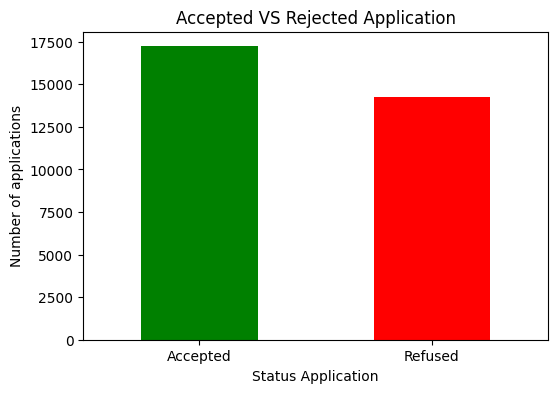

In [34]:
applications_status =df.groupby('case:ApplicationID')['concept:name'].apply(lambda concept: 'Accepted' if 'O_Accepted' in concept.values else 'Refused')

applications_count = applications_status.value_counts()

plt.figure(figsize=(6,4))
applications_count.plot(kind='bar', color=['green','red'])
plt.title('Accepted VS Rejected Application')
plt.xlabel('Status Application')
plt.ylabel('Number of applications')
plt.xticks(rotation=0)
plt.show()


**Reading the "Distribution of the number of offers per application" chart**

This chart lets us see whether most applications received just one offer or whether there are cases where multiple offers were made for the same application. It also makes it easy to spot any outliers — applications that ended up with a unusually high number of offers.

In short, it helps understand how complex the offering process gets at the application level, and how often multiple offers are generated for a single application.

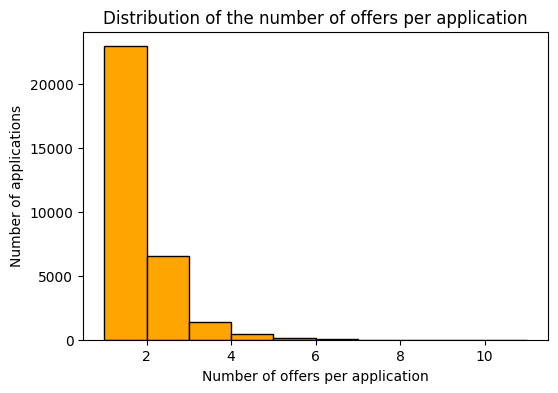

In [35]:
offers_per_applications = df.groupby('case:ApplicationID')['case:concept:name'].nunique()

plt.figure(figsize=(6,4))
plt.hist(offers_per_applications, bins=range(1, offers_per_applications.max()+2), color='orange', edgecolor='black')
plt.title('Distribution of the number of offers per application')
plt.xlabel('Number of offers per application')
plt.ylabel('Number of applications')
plt.show()


**Reading the "Waiting time until offer acceptance (in days)" chart**

X Axis (Days)

Represents the number of days between the moment an offer was created (O_Create Offer) and the moment it was accepted (O_Accepted).

Each bar in the histogram corresponds to a range of days.

Y Axis (Number of offers)

Shows how many offers fell within each waiting time range.

The height of each bar indicates the number of offers that were accepted after a certain number of days.

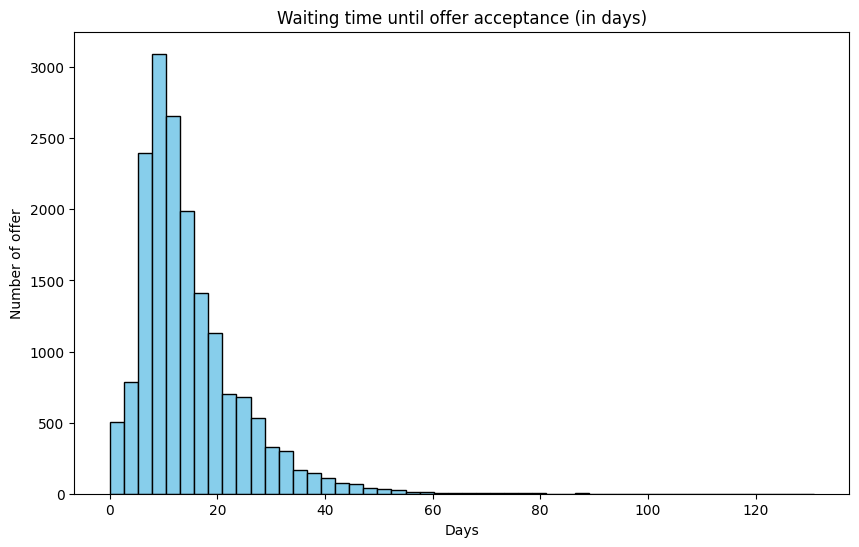

In [36]:
accepted_offers = df[df['concept:name'].isin(['O_Create Offer', 'O_Accepted'])]

offer_times = accepted_offers.pivot(index='case:concept:name', columns='concept:name', values='time:timestamp')

offer_times['waiting_time_days'] = (offer_times['O_Accepted'] - offer_times['O_Create Offer']).dt.total_seconds() / (24*3600)

plt.figure(figsize=(10,6))
plt.hist(offer_times['waiting_time_days'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title("Waiting time until offer acceptance (in days)")
plt.xlabel("Days")
plt.ylabel("Number of offer")
plt.show()


**Reading the "Distribution of the number of terms for accepted offers" chart**

This chart shows the distribution of the number of terms (installments) for offers that were accepted by clients. The horizontal axis displays the number of terms, while the vertical axis shows how many offers fall within each range.

The histogram makes it easy to see where accepted offers are concentrated based on their duration. You can quickly tell whether most clients tend to go for short, medium or long-term offers. Taller bars point to term ranges that show up more often, which suggests clients have a clear preference for those durations.

Overall, the chart is useful for understanding how clients behave when it comes to accepting offers.

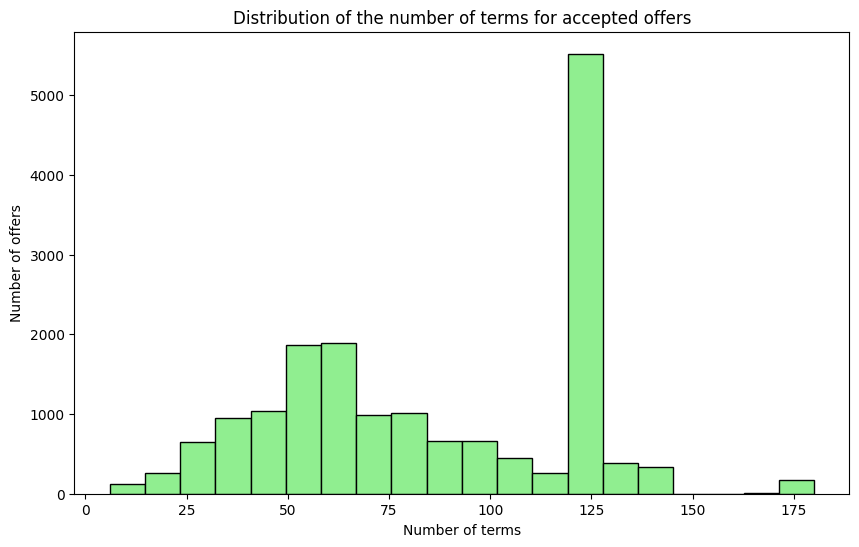

In [37]:
accepted_offers =df[df['concept:name'] == 'O_Accepted']
offer_terms = accepted_offers[['case:concept:name','case:NumberOfTerms']].drop_duplicates()

plt.figure(figsize=(10,6))
plt.hist(offer_terms['case:NumberOfTerms'],bins=20, color='lightgreen',edgecolor='black')
plt.title('Distribution of the number of terms for accepted offers')
plt.xlabel('Number of terms')
plt.ylabel('Number of offers')
plt.show()


**Reading the "Distribution of offered amounts for accepted offers" chart**

This histogram shows the distribution of offered amounts for offers that were accepted. It makes it easy to see which amount ranges clients tend to accept most often. Taller bars point to amounts that come up frequently in accepted offers, suggesting a comfort zone or a clear preference on the client's side. The chart helps identify the typical amounts where acceptance is most likely, and can later be used to compare against refused offer amounts or to fine-tune the offering strategy.

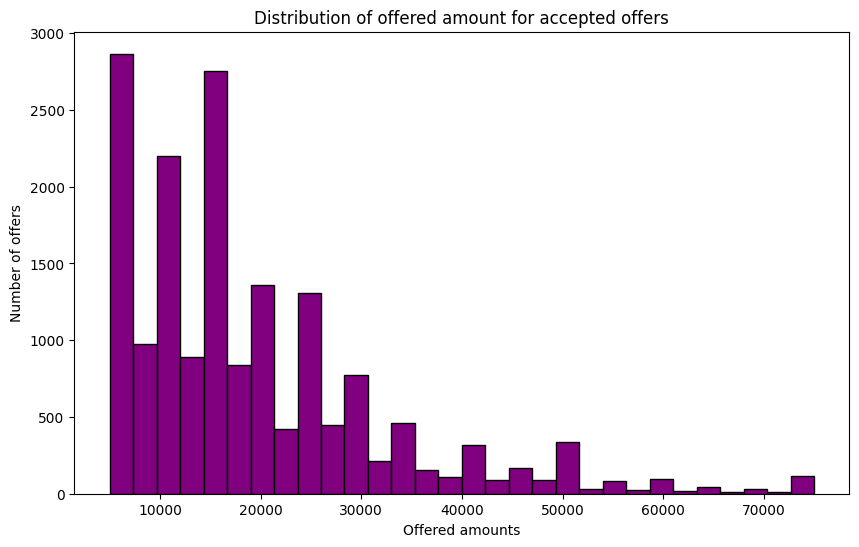

In [38]:
accepted_offers = df[df['concept:name'] == 'O_Accepted']
offer_amounts = accepted_offers[['case:concept:name','case:OfferedAmount']].drop_duplicates()

plt.figure(figsize=(10,6))
plt.hist(offer_amounts['case:OfferedAmount'], bins=30, color='purple',edgecolor='black')
plt.title('Distribution of offered amount for accepted offers')
plt.xlabel('Offered amounts')
plt.ylabel('Number of offers')
plt.show()

**Reading the "Correlation between numerical variables" chart**

The correlation analysis shows that the financial parameters of offers (offered amount, monthly cost, and number of terms) are closely tied to each other, which reflects sound lending logic.
Credit score, on the other hand, shows no meaningful correlation with any of these parameters — suggesting it is used more as an eligibility criterion rather than a factor in shaping the offer itself.

1. MonthlyCost -> OfferedAmount (0.71 = strong positive correlation)

    The most important relationship in the chart
    The higher the offered amount, the higher the monthly cost
    The monthly installment is calculated directly from the borrowed amount

2. MonthlyCost -> FirstWithdrawalAmount (0.36 = moderate correlation)

    A larger first withdrawal tends to lead to a higher monthly cost
    The relationship is there, but it's not the dominant one
    FirstWithdrawalAmount does influence monthly cost, just not as the main driver

3. OfferedAmount -> NumberOfTerms (0.41 = moderate positive correlation)

    Higher amounts tend to come with a higher number of terms
    The client "stretches" the loan over a longer period for larger amounts
    The institution adjusts the loan duration based on the amount

4. MonthlyCost ↔ NumberOfTerms (-0.18 = weak negative correlation)

    More terms → slightly lower monthly installment
    The correlation is weak, but it makes economic sense

5. CreditScore — the KEY observation

    CreditScore vs everything else (≈ 0)
    CreditScore has near-zero correlation with: MonthlyCost, OfferedAmount, NumberOfTerms, FirstWithdrawalAmount

    Credit score does not directly influence: the offered amount, monthly installment, or loan duration
    Most likely, CreditScore is used for eligibility (accepted / rejected) rather than for configuring the offer itself

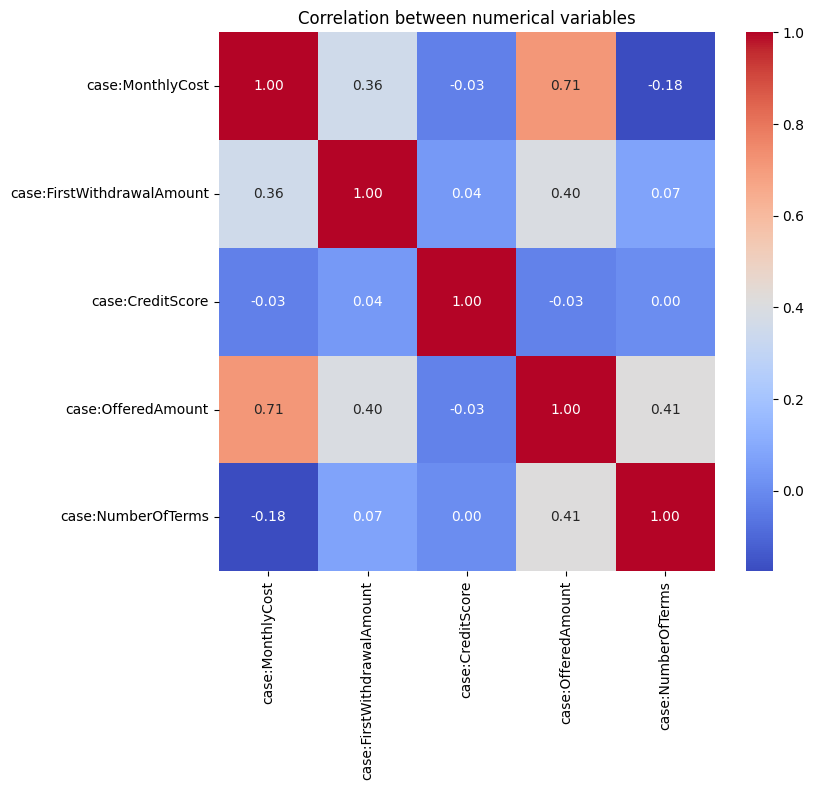

In [39]:
numeric_only = df.select_dtypes(include='number')
correlation_matrix = numeric_only.corr()

plt.figure(figsize=(8,7))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation between numerical variables')
plt.show()


**Reading the "Number of offers accepted after returned" chart**

Offers accepted after being returned sit at around 17,500. This represents the majority of returned offers, suggesting that many offers — even if initially returned — ended up being accepted by clients later on.

Offers rejected after being returned are just above 5,000. This means a smaller portion of returned offers never made it to acceptance.

What this tells us about client behavior:

Clients tend to accept most offers after returning them initially, possibly due to contract adjustments made afterwards or simply needing more time to make a decision.

There is a smaller segment that definitively refuses offers after returning them, which could point to a lack of interest or a mismatch between the offer and what the client was actually expecting.

/tmp/ipython-input-2952090241.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Status',y='Count', data=viz_df, palette='Set2')


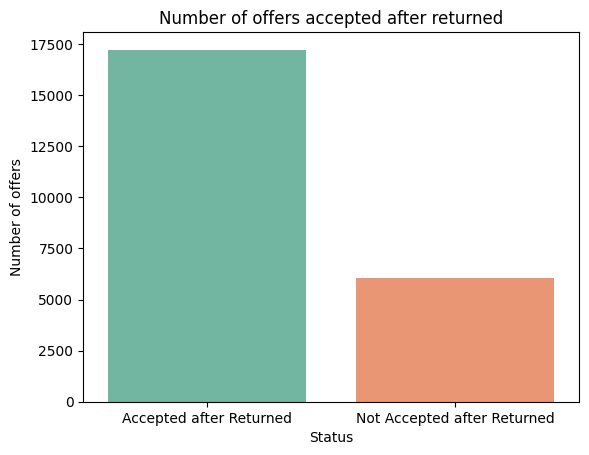

In [40]:
returned_offers = df[df['concept:name'] == "O_Returned"]['case:concept:name'].unique()
accepted_after_returned = df[
                              (df['case:concept:name'].isin(returned_offers)) &
                              (df['concept:name'] == 'O_Accepted')
                            ]['case:concept:name'].nunique()

total_offers_returned = len(returned_offers)

viz_df = pd.DataFrame({
                          "Status" : ['Accepted after Returned',"Not Accepted after Returned"],
                          "Count"  : [accepted_after_returned, total_offers_returned - accepted_after_returned]
})

sns.barplot(x='Status',y='Count', data=viz_df, palette='Set2')
plt.title('Number of offers accepted after returned')
plt.xlabel('Status')
plt.ylabel('Number of offers')
plt.show()

**Reading the "Top 10 users with the most accepted offers" chart**

Top 10 employees with the most accepted offers: the bars show which employees have marked the highest number of offers as accepted.

Number of accepted offers per employee: the length of each bar reflects the actual volume of work handled by each employee in the offer acceptance process.

/tmp/ipython-input-2024958436.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.values, y=top_users.index, palette='viridis')


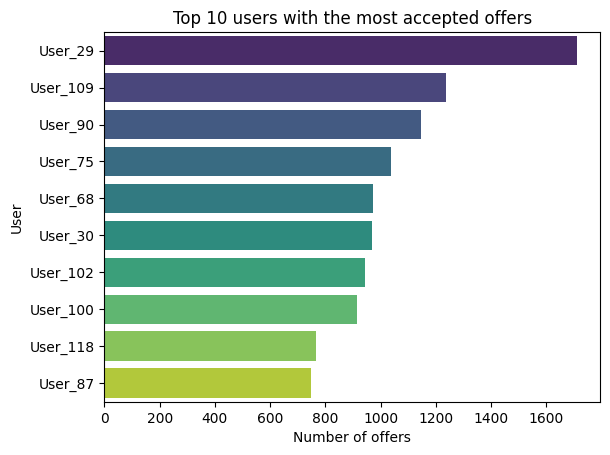

In [41]:
accepted_offers = df[df['concept:name'] == 'O_Accepted']

user_accept_count = accepted_offers.groupby('org:resource')['case:concept:name'].nunique().sort_values(ascending=False)

top_users = user_accept_count.head(10)
sns.barplot(x=top_users.values, y=top_users.index, palette='viridis')
plt.xlabel('Number of offers')
plt.ylabel('User')
plt.title('Top 10 users with the most accepted offers')
plt.show()


I run a contingency between the case:Selected and case:Accepted variables to answer the question -> "Does case:Accepted influence the probability of an offer being accepted by the client (i.e. having case:Selected = True)?"

1. Aggregation at the offer level

In [42]:
offers = df[['case:concept:name','case:Selected','case:Accepted']].drop_duplicates()

2. I create the contingency table

In [43]:
contingency = pd.crosstab(
    offers['case:Accepted'],
    offers['case:Selected'],
    margins=True
)

In [44]:
contingency

case:Selected,False,True,All
case:Accepted,,,
False,6842,6017,12859
True,14385,15751,30136
All,21227,21768,42995


**Reading the "Boxplot for all numerical variables - Outliers detection" chart**

The boxplot shows the distribution of numerical variables in the dataset, with the goal of spotting extreme values across the data as a whole.

For financial variables like MonthlyCost, FirstWithdrawalAmount and OfferedAmount, you can see a right-skewed distribution with a large number of outliers. This kind of behavior is typical for financial data and tells us that while most clients fall within a moderate range of values, there is a smaller group with very high amounts or costs. These extreme values are not data errors — they reflect real business situations involving clients who take out high-value loans.

CreditScore shows a much more stable distribution, with few outliers and low variability. This suggests that credit score is a standardized, controlled indicator used mainly to assess client eligibility rather than to fine-tune the financial parameters of an offer.

For NumberOfTerms, the distribution is tightly concentrated within a narrow range, with very few extreme values. This points to the existence of standardized loan durations tied to the financial products offered by the institution, while the outliers may represent special plans or atypical products.

Overall, the boxplot shows that the dataset is consistent and accurately reflects the reality of the lending process. The outliers found are explainable from a business perspective and should not be removed automatically. In later modeling stages, they can be handled through appropriate techniques — such as log transformations or robust methods — without losing relevant information.

This analysis confirms that the data is suitable for building a predictive model, as long as the financial variables with strongly skewed distributions are handled with care.

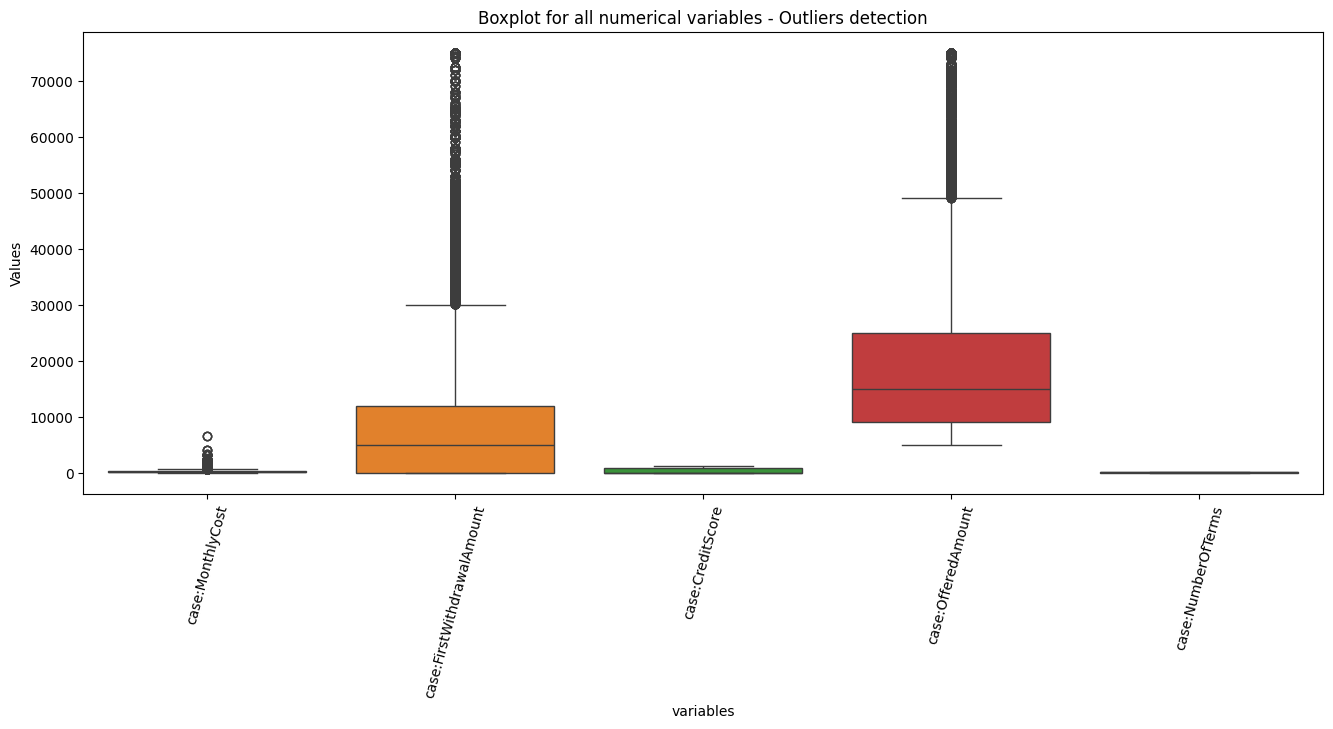

In [45]:
numeric_cols = df.select_dtypes(include='number')

plt.figure(figsize=(16,6))
sns.boxplot(data=numeric_cols)
plt.title('Boxplot for all numerical variables - Outliers detection')
plt.xlabel('variables')
plt.ylabel('Values')
plt.xticks(rotation=75)
plt.show()

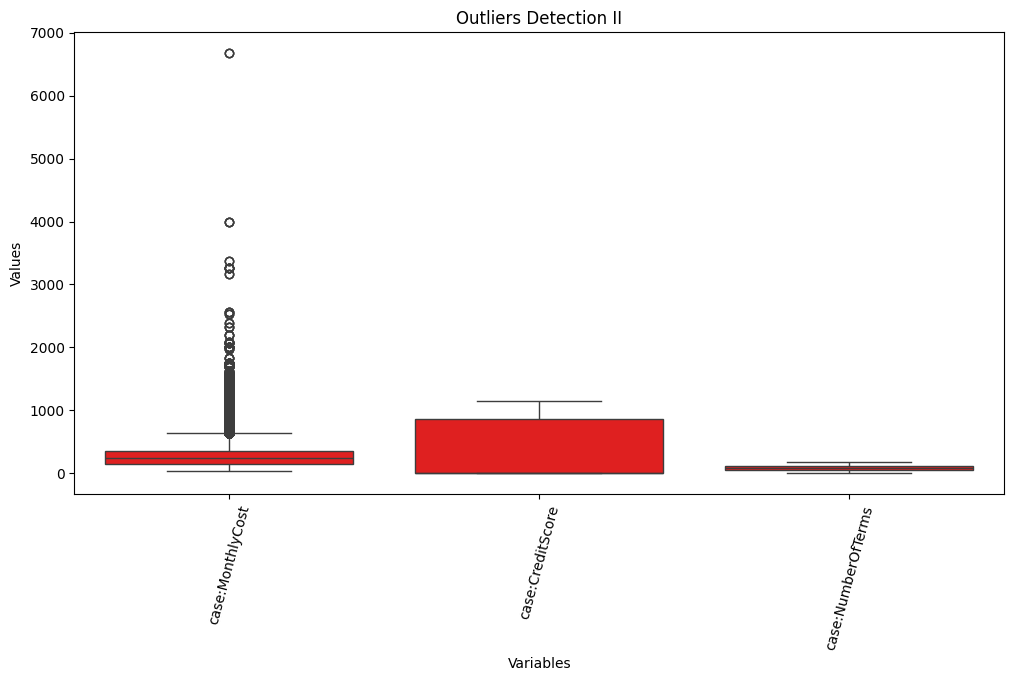

In [46]:
plt.figure(figsize=(12,6))
sns.boxplot(data = numeric_cols[['case:MonthlyCost','case:CreditScore','case:NumberOfTerms']], color='red')
plt.title('Outliers Detection II')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.xticks(rotation=75)
plt.show()

In [47]:
created_offers = df[df['concept:name'] == 'O_Created'].copy()
created_offers.shape

(42995, 17)

In [48]:
created_offers['time:timestamp'].dtype

datetime64[ns, UTC]

In [49]:
created_offers['year_month'] = created_offers['time:timestamp'].dt.to_period('M')

/tmp/ipython-input-297192128.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  created_offers['year_month'] = created_offers['time:timestamp'].dt.to_period('M')


In [50]:
created_offers[['time:timestamp','year_month']].head()

,time:timestamp,year_month
1,2016-01-02 09:17:08.762000+00:00,2016-01
5,2016-01-02 09:21:43.573000+00:00,2016-01
9,2016-01-02 09:26:44.925000+00:00,2016-01
13,2016-01-02 09:55:47.693000+00:00,2016-01
18,2016-01-02 10:35:10.063000+00:00,2016-01


**Reading the "Monthly evolution of created offers" chart**

This chart shows the monthly evolution of the number of created offers, giving a detailed look at how the offering process changed over time.

During the January–September 2016 period, there is a general upward trend, with a peak in the summer months (around June–August). This suggests a surge in offering activity, possibly driven by seasonal factors or the institution's commercial policies.

After this peak, the last few months of 2016 show a slight decline, followed by a sharp drop at the beginning of 2017. This drop does not reflect an actual reduction in activity — it is again explained by the fact that the 2017 data is partial, as the dataset ends at the beginning of that year.

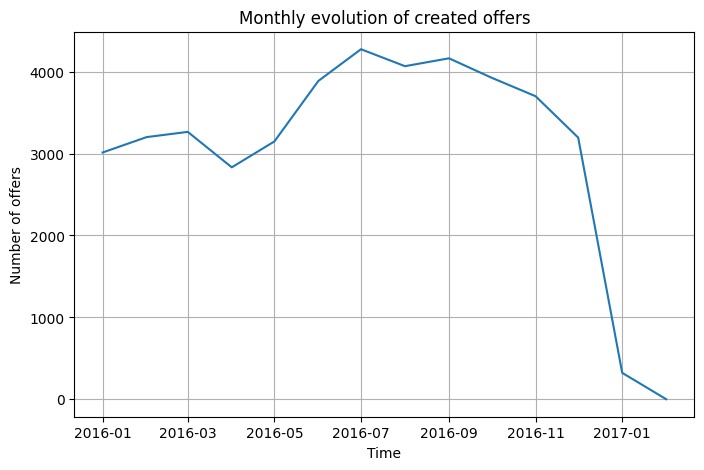

In [51]:
offers_per_month = created_offers.groupby('year_month')['case:concept:name'].nunique()

offers_per_month.index = offers_per_month.index.to_timestamp()

plt.figure(figsize=(8,5))
plt.plot(offers_per_month.index, offers_per_month.values)
plt.title('Monthly evolution of created offers')
plt.xlabel('Time')
plt.ylabel('Number of offers')
plt.grid(True)
plt.show()


In [52]:
offers_per_month.head()
offers_per_month.tail()


,case:concept:name
year_month,
2016-10-01,3926
2016-11-01,3700
2016-12-01,3195
2017-01-01,323
2017-02-01,1


**Renaming columns for better understanding**

In [53]:
df.columns

Index(['Action', 'org:resource', 'concept:name', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time:timestamp', 'case:concept:name',
       'case:MonthlyCost', 'case:Selected', 'case:ApplicationID',
       'case:FirstWithdrawalAmount', 'case:CreditScore', 'case:OfferedAmount',
       'case:NumberOfTerms', 'case:Accepted', 'OfferID'],
      dtype='object')

In [54]:
df = df.rename(columns={
    'Action' : 'event_action',
    'org:resource' : 'org_resource',
    'concept:name' : 'event_type',
    'EventOrigin' : 'event_origin',
    'EventID' : 'event_id',
    'lifecycle:transition' : 'lifecycle_transition',
    'time:timestamp' : 'timestamp',
    'case:concept:name' : 'offer_id',
    'case:MonthlyCost' : 'monthly_cost',
    'case:Selected' : 'selected_by_client',
    'case:ApplicationID' : 'application_id',
    'case:FirstWithdrawalAmount' : 'first_withdrawal_amount',
    'case:CreditScore' : 'credit_score',
    'case:OfferedAmount' : 'offered_amount',
    'case:NumberOfTerms' : 'number_of_terms',
    'case:Accepted' : 'case_validation',
    'OfferID' : 'offer_ref_id'

})

In [55]:
df.head()

,event_action,org_resource,event_type,event_origin,event_id,lifecycle_transition,timestamp,offer_id,monthly_cost,selected_by_client,application_id,first_withdrawal_amount,credit_score,offered_amount,number_of_terms,case_validation,offer_ref_id
0,Created,User_17,O_Create Offer,Offer,Offer_247135719,complete,2016-01-02 09:17:05.720000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,NaN
1,statechange,User_17,O_Created,Offer,OfferState_124849367,complete,2016-01-02 09:17:08.762000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
2,statechange,User_17,O_Sent (online only),Offer,OfferState_440662877,complete,2016-01-02 09:19:21.330000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
3,statechange,User_17,O_Cancelled,Offer,OfferState_591416028,complete,2016-01-02 09:21:26.034000+00:00,Offer_247135719,201.76,False,Application_196483749,10000.0,0,10000.0,57,True,Offer_247135719
4,Created,User_17,O_Create Offer,Offer,Offer_941964966,complete,2016-01-02 09:21:42.022000+00:00,Offer_941964966,201.76,False,Application_196483749,4100.0,0,10000.0,57,True,NaN


**Preparing the dataset for machine learning** -> Aggregation + Feature Engineering

In [56]:
df['timestamp'].dtype

datetime64[ns, UTC]

In [57]:
offers_df = df.groupby('offer_id').agg(
    application_id = ('application_id', 'first'),

    offered_amount = ('offered_amount', 'first'),
    monthly_cost = ('monthly_cost', 'first'),
    number_of_terms = ('number_of_terms', 'first'),
    first_withdrawal_amount = ('first_withdrawal_amount', 'first'),
    credit_score = ('credit_score', 'first'),

    selected_by_client = ('selected_by_client', 'max'),

    offer_created_at = ('timestamp', 'min'),
    offer_accepted_at = (
        'timestamp',
        lambda x: x[df.loc[x.index, 'event_type'] == 'O_Accepted'].min()
    ),

    n_events = ('event_type', 'count'),
    n_returned = ('event_type', lambda x: (x == 'O_Returned').sum()),
    was_returned = ('event_type', lambda x: int((x == 'O_Returned').any())),
    was_cancelled = ('event_type', lambda x: int((x == 'O_Cancelled').any())),
    was_refused = ('event_type', lambda x: int((x == 'O_Refused').any())),
).reset_index()

In [58]:
offers_df['time_to_accept_days'] = (
    offers_df['offer_accepted_at'] - offers_df['offer_created_at']
).dt.total_seconds() / (24 * 3600)

In [59]:
offers_df.head(20)

,offer_id,application_id,offered_amount,monthly_cost,number_of_terms,first_withdrawal_amount,credit_score,selected_by_client,offer_created_at,offer_accepted_at,n_events,n_returned,was_returned,was_cancelled,was_refused,time_to_accept_days
0,Offer_1000096910,Application_922511317,8500.0,165.57,60,8500.00,0,False,2016-08-08 14:40:11.869000+00:00,NaT,4,0,0,1,0,NaN
1,Offer_1000145087,Application_1346612073,6250.0,105.00,71,0.00,0,True,2016-11-12 13:37:16.174000+00:00,2016-11-28 11:55:40.887000+00:00,5,1,1,0,0,15.929453
2,Offer_1000159595,Application_1616117711,16000.0,164.39,120,16000.00,0,False,2016-10-26 17:04:31.517000+00:00,NaT,3,0,0,1,0,NaN
3,Offer_1000226917,Application_509114641,24200.0,334.29,84,21.00,914,True,2016-09-27 09:55:04.058000+00:00,2016-09-28 14:10:32.745000+00:00,5,1,1,0,0,1.177415
4,Offer_100030769,Application_1670839360,11000.0,119.69,120,11000.00,0,False,2016-05-03 09:55:56.238000+00:00,NaT,4,0,0,1,0,NaN
5,Offer_1000329580,Application_125636605,5600.0,389.24,15,957.39,680,True,2016-02-22 16:00:42.029000+00:00,2016-03-07 11:33:58.694000+00:00,5,1,1,0,0,13.814776
6,Offer_1000360919,Application_1637171414,5000.0,206.27,26,5000.00,0,False,2016-08-30 13:35:53.880000+00:00,NaT,4,0,0,1,0,NaN
7,Offer_1000373613,Application_2044530341,5000.0,100.00,58,4550.00,982,True,2016-03-02 08:17:32.564000+00:00,2016-03-08 10:37:31.464000+00:00,5,1,1,0,0,6.097209
8,Offer_1000377420,Application_2131199353,5000.0,222.31,24,5000.00,0,False,2016-11-21 08:28:10.875000+00:00,NaT,4,0,0,1,0,NaN
9,Offer_1000572979,Application_845524112,30000.0,554.14,60,30000.00,956,True,2016-06-25 08:14:55.911000+00:00,2016-07-08 08:23:31.114000+00:00,5,1,1,0,0,13.005963


In [60]:
offers_df.shape

(42995, 16)

In [61]:
offers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42995 entries, 0 to 42994
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   offer_id                 42995 non-null  object             
 1   application_id           42995 non-null  object             
 2   offered_amount           42995 non-null  float64            
 3   monthly_cost             42995 non-null  float64            
 4   number_of_terms          42995 non-null  int64              
 5   first_withdrawal_amount  42995 non-null  float64            
 6   credit_score             42995 non-null  int64              
 7   selected_by_client       42995 non-null  bool               
 8   offer_created_at         42995 non-null  datetime64[ns, UTC]
 9   offer_accepted_at        17228 non-null  datetime64[ns, UTC]
 10  n_events                 42995 non-null  int64              
 11  n_returned               429

In [62]:
offers_df.isnull().sum().sort_values(ascending=False)

,0
time_to_accept_days,25767
offer_accepted_at,25767
offer_id,0
application_id,0
number_of_terms,0
first_withdrawal_amount,0
offered_amount,0
monthly_cost,0
selected_by_client,0
credit_score,0


**Reading the "Distribution of offers selected by client" chart**

The chart shows the distribution of offers at the offer level, based on the client's final decision, represented by the selected_by_client variable. The horizontal axis separates offers accepted by the client (True) from those not accepted (False), while the vertical axis shows the total number of offers in each category.

The data shows that the two categories are almost perfectly balanced. The difference between the two classes is very small (≈1.25%), which means there is no class imbalance to worry about.

This balanced distribution is very favorable for the modeling stages ahead — accuracy becomes a relevant metric alongside precision, recall and F1-score.

The result suggests that the offering process is well calibrated: roughly half of the generated offers are adapted closely enough to the client's profile to be accepted. This points to a mature offering process where the financial parameters and contract terms are, in general, aligned with what clients expect.

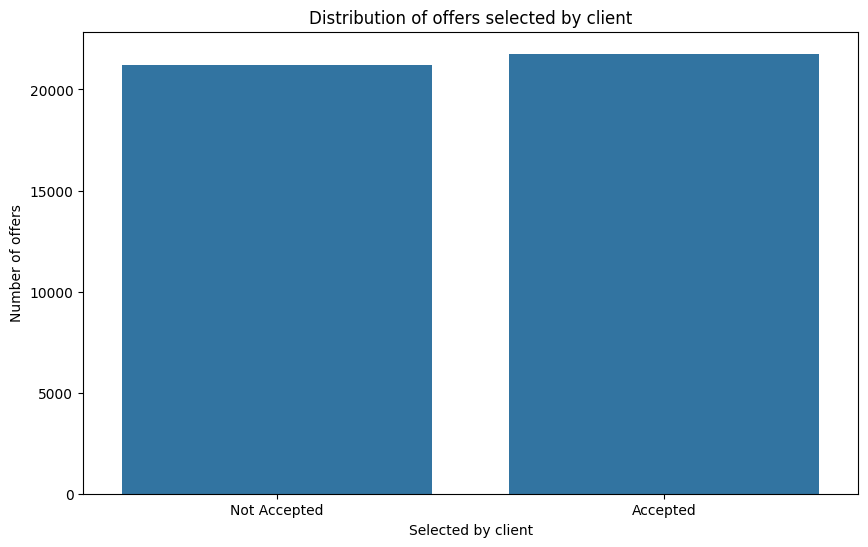

In [63]:
plt.figure(figsize=(10,6))
sns.countplot(
    x = 'selected_by_client',
    data = offers_df
)
plt.title('Distribution of offers selected by client')
plt.xlabel('Selected by client')
plt.ylabel('Number of offers')
plt.xticks([0,1],['Not Accepted','Accepted'])
plt.show()

In [64]:
offers_df['selected_by_client'].value_counts()

,count
selected_by_client,
True,21768
False,21227


**Reading the "Offered amount vs Client Decision" chart**

The distribution of the offered amount looks very similar for both accepted and non-accepted offers. The median is slightly higher for accepted offers, which suggests that marginally larger amounts may have a slightly higher chance of being accepted — but the difference is not significant. The interquartile ranges are nearly identical, meaning that most offers, regardless of the client's decision, fall within the same value ranges. The large number of outliers in both categories shows that offers with very high amounts can go either way — accepted or rejected. Overall, this tells us that the offered amount on its own is not a decisive factor in whether an offer gets accepted, and needs to be looked at together with other financial and behavioral variables.

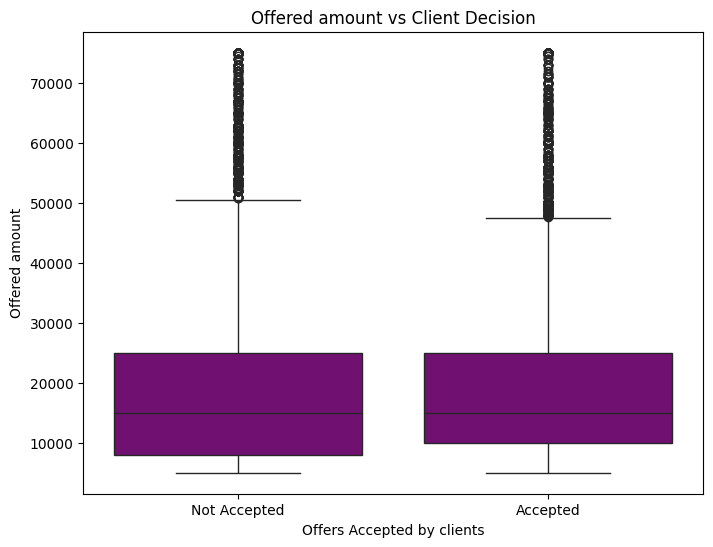

In [65]:
plt.figure(figsize=(8,6))
sns.boxplot(
    x = 'selected_by_client',
    y = 'offered_amount',
    data = offers_df,
    color='purple'
)
plt.title('Offered amount vs Client Decision')
plt.xlabel('Offers Accepted by clients')
plt.ylabel('Offered amount')
plt.xticks([0,1],['Not Accepted','Accepted'])
plt.show()

In [66]:
offers_df[(offers_df['offered_amount'] >= 50000) & (offers_df['selected_by_client'] == True)][['offer_id','selected_by_client']].count()

,0
offer_id,1049
selected_by_client,1049


In [67]:
offers_df[(offers_df['offered_amount']>= 50000) & (offers_df['selected_by_client'] == False)][['offer_id', 'selected_by_client']].count()

,0
offer_id,1109
selected_by_client,1109


**Reading the "Monthly Cost vs Client Decision" chart**

The chart shows that the monthly cost distribution looks very similar between accepted and non-accepted offers. The medians are close, with a slight tendency for accepted offers to have a marginally lower monthly cost — but the difference is small and does not point to a clear separation between the two categories. The interquartile ranges are comparable, suggesting that most offers, regardless of the client's decision, fall within the same monthly cost range. There are many outliers in both groups, especially among non-accepted offers, where some very high monthly costs appear — possibly linked to less attractive financial conditions. Overall, monthly cost alone does not seem to be a decisive factor in offer acceptance, and most likely works together with other offer-level variables rather than acting on its own.

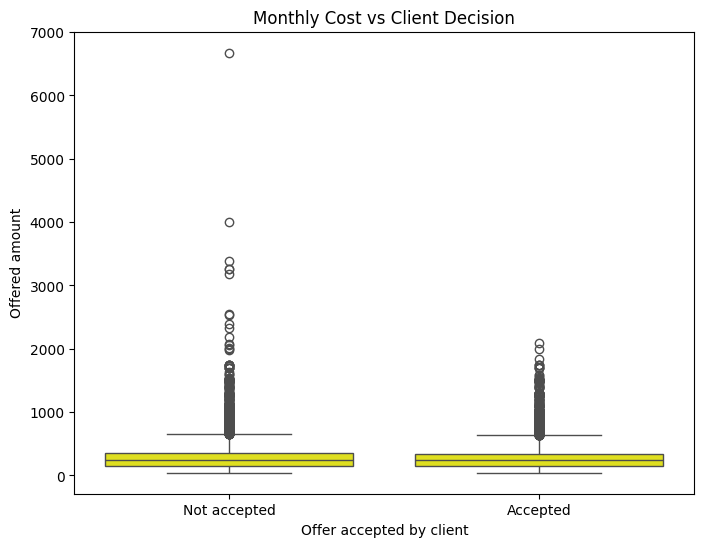

In [68]:
plt.figure(figsize=(8,6))
sns.boxplot(
    x='selected_by_client',
    y='monthly_cost',
    data=offers_df,
    color='yellow'
)

plt.xticks([0, 1], ['Not accepted', 'Accepted'])
plt.title('Monthly Cost vs Client Decision')
plt.xlabel('Offer accepted by client')
plt.ylabel('Offered amount')
plt.show()


**Reading the "Credit Score vs Client Decision" chart**

The chart shows a clear difference between the credit scores of clients who accept an offer and those who don't. Accepted offers are associated with much higher credit scores, with a median around 800–900 and a wide distribution, indicating that most financially creditworthy clients tend to accept the offers they receive. For non-accepted offers, on the other hand, the credit score is almost always 0, with only a few isolated outliers. The main pattern here is that credit score is a strong determining factor in the client's decision, and values of 0 appear to represent a distinct segment.

Insight / Finding

The boxplot clearly highlighted extreme values in the "Not accepted" category (selected_by_client = False) — exactly 3 offers with a very high credit score: 783, 825 and 1064. Additional queries also revealed the following:

Offers with a credit score of 0:

1. The "Not accepted" category (selected_by_client = False) has 21,224 offers with a credit score of 0.

2. The "Accepted" category (selected_by_client = True) has 6,511 offers with a credit score of 0.

Why this finding matters for the model:

The presence of 6,511 accepted offers with a score of 0 means that a value of 0 should not automatically be treated as a "Not accepted" indicator.
If the model were to interpret all 0 values as "Not accepted", it would introduce significant bias, since there is a substantial number of accepted offers with a credit score of 0.
This analysis supports the need to handle score 0 correctly during data preprocessing and when predicting the client's decision.

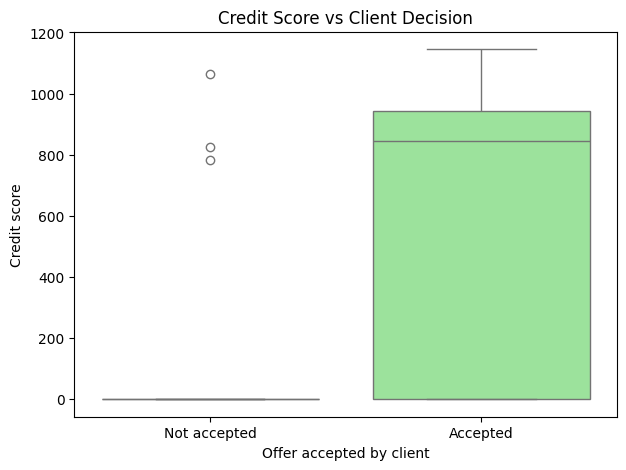

In [69]:
plt.figure(figsize=(7,5))
sns.boxplot(
    x='selected_by_client',
    y='credit_score',
    data=offers_df,
    color='lightgreen'
)

plt.xticks([0, 1], ['Not accepted', 'Accepted'])
plt.title('Credit Score vs Client Decision')
plt.xlabel('Offer accepted by client')
plt.ylabel('Credit score')
plt.show()


In [70]:
offers_df[(offers_df['selected_by_client']== False) & (offers_df['credit_score'] > 0)]

,offer_id,application_id,offered_amount,monthly_cost,number_of_terms,first_withdrawal_amount,credit_score,selected_by_client,offer_created_at,offer_accepted_at,n_events,n_returned,was_returned,was_cancelled,was_refused,time_to_accept_days
1208,Offer_105281745,Application_85362119,5000.0,56.30,120,5000.0,783,False,2016-04-11 11:57:00.741000+00:00,NaT,5,1,1,1,0,NaN
1834,Offer_108202183,Application_2095055090,25000.0,254.56,120,6980.0,825,False,2016-09-17 11:03:08.388000+00:00,NaT,5,1,1,1,0,NaN
7930,Offer_1351452430,Application_1030416681,15000.0,157.59,120,15000.0,1064,False,2016-05-26 13:40:49.250000+00:00,NaT,5,1,1,1,0,NaN


In [71]:
offers_df[(offers_df['selected_by_client']== False) & (offers_df['credit_score'] == 0)]

,offer_id,application_id,offered_amount,monthly_cost,number_of_terms,first_withdrawal_amount,credit_score,selected_by_client,offer_created_at,offer_accepted_at,n_events,n_returned,was_returned,was_cancelled,was_refused,time_to_accept_days
0,Offer_1000096910,Application_922511317,8500.0,165.57,60,8500.0,0,False,2016-08-08 14:40:11.869000+00:00,NaT,4,0,0,1,0,NaN
2,Offer_1000159595,Application_1616117711,16000.0,164.39,120,16000.0,0,False,2016-10-26 17:04:31.517000+00:00,NaT,3,0,0,1,0,NaN
4,Offer_100030769,Application_1670839360,11000.0,119.69,120,11000.0,0,False,2016-05-03 09:55:56.238000+00:00,NaT,4,0,0,1,0,NaN
6,Offer_1000360919,Application_1637171414,5000.0,206.27,26,5000.0,0,False,2016-08-30 13:35:53.880000+00:00,NaT,4,0,0,1,0,NaN
8,Offer_1000377420,Application_2131199353,5000.0,222.31,24,5000.0,0,False,2016-11-21 08:28:10.875000+00:00,NaT,4,0,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42982,Offer_999475701,Application_1308473984,10000.0,143.97,84,10000.0,0,False,2016-05-26 17:16:14.236000+00:00,NaT,5,1,1,1,0,NaN
42984,Offer_999507013,Application_685451921,15000.0,1279.40,12,15000.0,0,False,2016-11-03 16:43:09.505000+00:00,NaT,5,1,1,1,0,NaN
42985,Offer_999573930,Application_1374324644,5000.0,50.00,138,5000.0,0,False,2016-11-08 17:33:53.222000+00:00,NaT,5,1,1,1,0,NaN
42990,Offer_999806196,Application_1682379587,19000.0,190.00,127,19000.0,0,False,2016-04-12 09:25:30.161000+00:00,NaT,5,1,1,1,0,NaN


In [72]:
offers_df[(offers_df['selected_by_client']== True) & (offers_df['credit_score'] == 0)]

,offer_id,application_id,offered_amount,monthly_cost,number_of_terms,first_withdrawal_amount,credit_score,selected_by_client,offer_created_at,offer_accepted_at,n_events,n_returned,was_returned,was_cancelled,was_refused,time_to_accept_days
1,Offer_1000145087,Application_1346612073,6250.0,105.00,71,0.0,0,True,2016-11-12 13:37:16.174000+00:00,2016-11-28 11:55:40.887000+00:00,5,1,1,0,0,15.929453
13,Offer_1000765928,Application_1510106241,6000.0,147.20,46,2503.0,0,True,2016-09-24 11:07:36.226000+00:00,NaT,5,1,1,0,1,NaN
15,Offer_1000827448,Application_872415486,20000.0,593.27,36,13176.0,0,True,2016-11-01 10:40:22.929000+00:00,NaT,5,1,1,0,1,NaN
25,Offer_1001553250,Application_1607028451,17500.0,175.00,127,2500.0,0,True,2016-01-15 18:16:41.868000+00:00,2016-01-26 10:14:10.052000+00:00,5,1,1,0,0,10.664910
27,Offer_1001568929,Application_205163550,5000.0,97.40,60,5000.0,0,True,2016-07-28 12:46:31.995000+00:00,NaT,5,1,1,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42969,Offer_998927749,Application_2124615783,38000.0,604.03,71,38000.0,0,True,2016-11-18 09:27:59.845000+00:00,NaT,5,1,1,0,1,NaN
42974,Offer_999180107,Application_11164910,15000.0,250.00,69,0.0,0,True,2016-04-01 16:03:11.294000+00:00,2016-04-08 14:36:03.565000+00:00,5,1,1,0,0,6.939494
42977,Offer_999299527,Application_141572677,25000.0,435.79,64,25000.0,0,True,2017-01-12 15:07:07.085000+00:00,NaT,4,1,1,0,0,NaN
42987,Offer_999648055,Application_1140000103,6000.0,99.20,73,6000.0,0,True,2016-10-26 11:06:57.962000+00:00,NaT,5,1,1,0,1,NaN


**Reading the "Number Of Terms vs Client Decision" chart**

The chart shows that the distribution of the number of installments is very similar between accepted and non-accepted offers. There is however a slight difference at the median level, suggesting a tendency for clients to more often accept offers with a higher number of installments — meaning they prefer spreading the loan over a longer period of time. The interquartile ranges are practically identical for both categories, which shows that regardless of the client's decision, most offers fall within the same range of term values. Overall, the number of installments on its own does not appear to be a decisive factor in offer acceptance, and its influence is more likely felt in combination with other offer parameters.

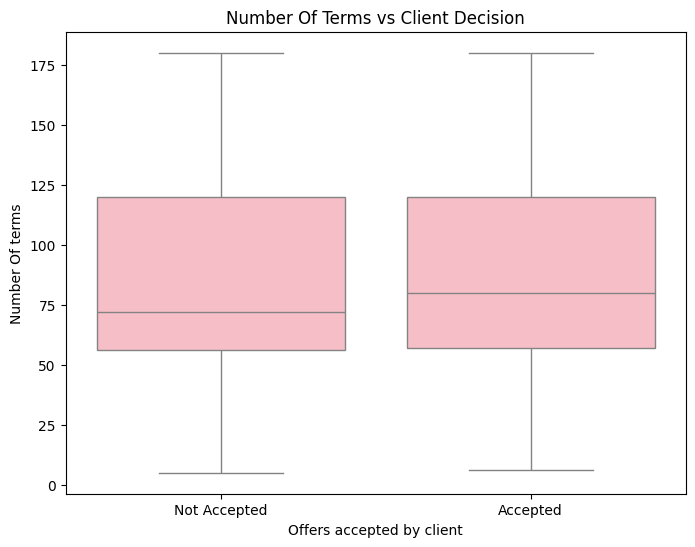

In [73]:
plt.figure(figsize=(8,6))

sns.boxplot(x='selected_by_client',
            y='number_of_terms',
            data=offers_df,
            color='lightpink')

plt.xticks((0,1),['Not Accepted','Accepted'])
plt.title('Number Of Terms vs Client Decision')
plt.xlabel('Offers accepted by client')
plt.ylabel('Number Of terms')
plt.show()


**Reading the "First Withdrawal Amount vs Client Decision" chart**

The chart suggests that the level of the first amount available for withdrawal does not clearly differentiate accepted offers from rejected ones. The central values of the two distributions are close, with only a slight lean towards larger initial amounts in the case of non-accepted offers — though this does not point to any distinct behavioral pattern. The spread of values is similar across both categories, showing that most offers cluster within the same first withdrawal range regardless of the client's decision. The presence of several outliers, particularly among non-accepted offers, indicates that some offers carry unusually large initial amounts, which may reflect less favorable contract conditions. Overall, the first amount available for withdrawal does not appear to decisively influence the client's choice — it is more of a complementary element, evaluated alongside the other terms of the offer.

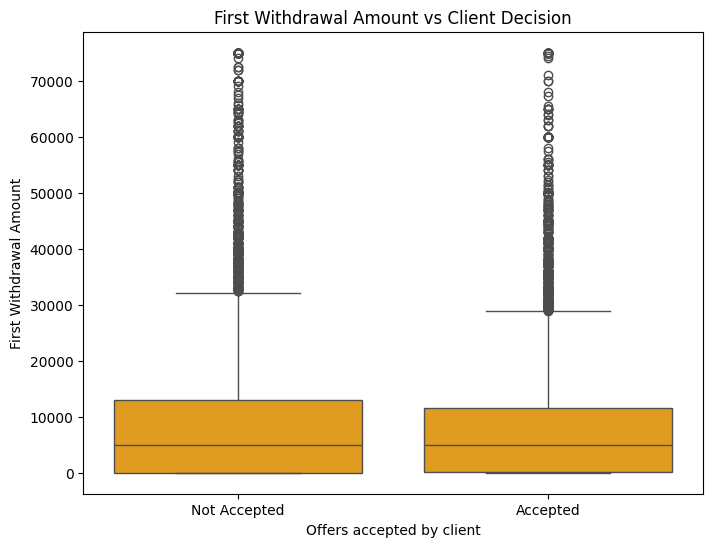

In [74]:
plt.figure(figsize=(8,6))

sns.boxplot(x='selected_by_client',
            y='first_withdrawal_amount',
            data=offers_df,
            color='orange')

plt.xticks((0,1),['Not Accepted','Accepted'])
plt.title('First Withdrawal Amount vs Client Decision')
plt.xlabel('Offers accepted by client')
plt.ylabel('First Withdrawal Amount')
plt.show()

In [75]:
offers_df[(offers_df['selected_by_client'] == True) & (offers_df['first_withdrawal_amount'] > 30000)][['selected_by_client','first_withdrawal_amount']].sort_values(by='first_withdrawal_amount',ascending=False)

,selected_by_client,first_withdrawal_amount
42691,True,75000.00
41521,True,75000.00
41065,True,75000.00
1649,True,75000.00
2596,True,75000.00
...,...,...
31198,True,30324.58
7731,True,30184.00
3677,True,30180.00
23796,True,30175.00


In [76]:
offers_df[offers_df['selected_by_client'] == True].head(60)

,offer_id,application_id,offered_amount,monthly_cost,number_of_terms,first_withdrawal_amount,credit_score,selected_by_client,offer_created_at,offer_accepted_at,n_events,n_returned,was_returned,was_cancelled,was_refused,time_to_accept_days
1,Offer_1000145087,Application_1346612073,6250.0,105.00,71,0.00,0,True,2016-11-12 13:37:16.174000+00:00,2016-11-28 11:55:40.887000+00:00,5,1,1,0,0,15.929453
3,Offer_1000226917,Application_509114641,24200.0,334.29,84,21.00,914,True,2016-09-27 09:55:04.058000+00:00,2016-09-28 14:10:32.745000+00:00,5,1,1,0,0,1.177415
5,Offer_1000329580,Application_125636605,5600.0,389.24,15,957.39,680,True,2016-02-22 16:00:42.029000+00:00,2016-03-07 11:33:58.694000+00:00,5,1,1,0,0,13.814776
7,Offer_1000373613,Application_2044530341,5000.0,100.00,58,4550.00,982,True,2016-03-02 08:17:32.564000+00:00,2016-03-08 10:37:31.464000+00:00,5,1,1,0,0,6.097209
9,Offer_1000572979,Application_845524112,30000.0,554.14,60,30000.00,956,True,2016-06-25 08:14:55.911000+00:00,2016-07-08 08:23:31.114000+00:00,5,1,1,0,0,13.005963
10,Offer_1000681710,Application_2131314372,16000.0,200.00,96,14500.00,956,True,2016-02-02 09:24:54.170000+00:00,2016-02-09 15:55:41.368000+00:00,5,1,1,0,0,7.271380
11,Offer_1000683509,Application_720331822,5000.0,222.31,24,2616.32,928,True,2016-08-08 15:10:29.301000+00:00,2016-08-16 08:05:02.088000+00:00,5,1,1,0,0,7.704546
12,Offer_1000765148,Application_365564661,21400.0,224.82,120,1.00,991,True,2016-03-09 14:14:48.481000+00:00,2016-03-30 09:16:38.981000+00:00,5,1,1,0,0,20.792946
13,Offer_1000765928,Application_1510106241,6000.0,147.20,46,2503.00,0,True,2016-09-24 11:07:36.226000+00:00,NaT,5,1,1,0,1,NaN
15,Offer_1000827448,Application_872415486,20000.0,593.27,36,13176.00,0,True,2016-11-01 10:40:22.929000+00:00,NaT,5,1,1,0,1,NaN


**Applying ML Model**

1. Logistic Regression

In [77]:
offers_df.head()

,offer_id,application_id,offered_amount,monthly_cost,number_of_terms,first_withdrawal_amount,credit_score,selected_by_client,offer_created_at,offer_accepted_at,n_events,n_returned,was_returned,was_cancelled,was_refused,time_to_accept_days
0,Offer_1000096910,Application_922511317,8500.0,165.57,60,8500.0,0,False,2016-08-08 14:40:11.869000+00:00,NaT,4,0,0,1,0,NaN
1,Offer_1000145087,Application_1346612073,6250.0,105.00,71,0.0,0,True,2016-11-12 13:37:16.174000+00:00,2016-11-28 11:55:40.887000+00:00,5,1,1,0,0,15.929453
2,Offer_1000159595,Application_1616117711,16000.0,164.39,120,16000.0,0,False,2016-10-26 17:04:31.517000+00:00,NaT,3,0,0,1,0,NaN
3,Offer_1000226917,Application_509114641,24200.0,334.29,84,21.0,914,True,2016-09-27 09:55:04.058000+00:00,2016-09-28 14:10:32.745000+00:00,5,1,1,0,0,1.177415
4,Offer_100030769,Application_1670839360,11000.0,119.69,120,11000.0,0,False,2016-05-03 09:55:56.238000+00:00,NaT,4,0,0,1,0,NaN


In [78]:
df_final = offers_df.copy()

In [79]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42995 entries, 0 to 42994
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   offer_id                 42995 non-null  object             
 1   application_id           42995 non-null  object             
 2   offered_amount           42995 non-null  float64            
 3   monthly_cost             42995 non-null  float64            
 4   number_of_terms          42995 non-null  int64              
 5   first_withdrawal_amount  42995 non-null  float64            
 6   credit_score             42995 non-null  int64              
 7   selected_by_client       42995 non-null  bool               
 8   offer_created_at         42995 non-null  datetime64[ns, UTC]
 9   offer_accepted_at        17228 non-null  datetime64[ns, UTC]
 10  n_events                 42995 non-null  int64              
 11  n_returned               429

In [80]:
df_final['selected_by_client'] = df_final['selected_by_client'].astype(int)

In [81]:
df_final['selected_by_client'].dtype

dtype('int64')

**Splitting Data**

In [82]:
X = df_final.drop(columns=['offer_id','application_id','selected_by_client','offer_created_at','offer_accepted_at','n_events','n_returned','was_returned',
                            'was_cancelled','was_refused','time_to_accept_days'])
y = df_final['selected_by_client']

In [83]:
X.shape

(42995, 5)

In [84]:
y.shape

(42995,)

In [85]:
X.head()

,offered_amount,monthly_cost,number_of_terms,first_withdrawal_amount,credit_score
0,8500.0,165.57,60,8500.0,0
1,6250.0,105.00,71,0.0,0
2,16000.0,164.39,120,16000.0,0
3,24200.0,334.29,84,21.0,914
4,11000.0,119.69,120,11000.0,0


In [86]:
y.head()

,selected_by_client
0,0
1,1
2,0
3,1
4,0


In [87]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [87]:
lr = LogisticRegression()

In [88]:
lr.fit(X_train,y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [89]:
y_pred_lr = lr.predict(X_test)

In [90]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87      4207
           1       1.00      0.70      0.83      4392

    accuracy                           0.85      8599
   macro avg       0.88      0.85      0.85      8599
weighted avg       0.88      0.85      0.85      8599



In [91]:
scores_lr = cross_val_score(lr,X,y,cv=5)
print(scores_lr)
print(np.mean(scores_lr))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[0.8445168  0.85463426 0.84881963 0.84405163 0.85033143]
0.8484707524130712


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Trying to scale X to improve results**

In [88]:
ss = StandardScaler()

In [89]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [90]:
lr_sc = LogisticRegression()

In [91]:
lr_sc.fit(X_train_sc,y_train)

LogisticRegression()

In [92]:
y_pred_lr_sc = lr_sc.predict(X_test_sc)

In [93]:
print(classification_report(y_test,y_pred_lr_sc))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87      4207
           1       1.00      0.70      0.83      4392

    accuracy                           0.85      8599
   macro avg       0.88      0.85      0.85      8599
weighted avg       0.88      0.85      0.85      8599



In [94]:
mm = MinMaxScaler()

In [95]:
X_train_mm = mm.fit_transform(X_train)
X_test_mm = mm.transform(X_test)

In [96]:
lr_mm = LogisticRegression()

In [97]:
lr_mm.fit(X_train_mm,y_train)

LogisticRegression()

In [98]:
y_pred_lr_mm = lr_mm.predict(X_test_mm)

In [99]:
print(classification_report(y_test,y_pred_lr_mm))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87      4207
           1       1.00      0.70      0.83      4392

    accuracy                           0.85      8599
   macro avg       0.88      0.85      0.85      8599
weighted avg       0.88      0.85      0.85      8599



Permutation Feature Importance for Logistic Regression

The 'rpi' variable represents the result object of the Permutation Feature Importance algorithm. The chosen evaluation metric is F1-score, as it provides a balance between precision and recall and more accurately reflects the impact of each variable on the model's ability to correctly identify offers accepted by clients.

In [ ]:
rpi = permutation_importance(
    lr_sc,
    X_test_sc,
    y_test,
    n_repeats = 10,
    random_state = 42,
    scoring = 'f1'
)

In [ ]:
perm_importance_df = pd.DataFrame({
    'features' : X.columns,
    'importance_mean' : rpi.importances_mean,
    'importance_std' : rpi.importances_std
}).sort_values(by='importance_mean', ascending=False)

The Permutation Feature Importance results indicate that credit_score is the dominant variable in the Logistic Regression model, having a significant impact on the F1 score. Permuting this variable causes a major drop in performance, while permuting the other variables does not meaningfully affect the model's predictions. This suggests that the acceptance decision is explained almost entirely by the credit score, and the other financial parameters do not bring any additional relevant information within this linear model.

In [ ]:
print(perm_importance_df)

                  features  importance_mean  importance_std
4             credit_score         0.404999        0.005174
1             monthly_cost         0.000077        0.000051
0           offered_amount         0.000000        0.000000
2          number_of_terms         0.000000        0.000000
3  first_withdrawal_amount         0.000000        0.000000


Training the model without credit_score + permutation importance

In [ ]:
X.head()

,offered_amount,monthly_cost,number_of_terms,first_withdrawal_amount,credit_score
0,8500.0,165.57,60,8500.0,0
1,6250.0,105.00,71,0.0,0
2,16000.0,164.39,120,16000.0,0
3,24200.0,334.29,84,21.0,914
4,11000.0,119.69,120,11000.0,0


In [ ]:
X_no_credit = X.drop(columns='credit_score')

In [ ]:
X_no_credit.head()

,offered_amount,monthly_cost,number_of_terms,first_withdrawal_amount
0,8500.0,165.57,60,8500.0
1,6250.0,105.00,71,0.0
2,16000.0,164.39,120,16000.0
3,24200.0,334.29,84,21.0
4,11000.0,119.69,120,11000.0


In [ ]:
X_no_credit_sc = ss.fit_transform(X_no_credit)

In [ ]:
X_train_no_credit_sc, X_test_no_credit_sc, y_train,y_test = train_test_split(X_no_credit_sc, y, test_size=0.2, random_state=42)

In [ ]:
lr_no_credit = LogisticRegression()

In [ ]:
lr_no_credit.fit(X_train_no_credit_sc,y_train)

LogisticRegression()

In [ ]:
y_pred_lr_no_credit_sc = lr_no_credit.predict(X_test_no_credit_sc)

Model performance interpretation WITHOUT credit_score

Key result:
Accuracy ≈ 0.53
F1-score ≈ 0.53
Precision and recall ~ 0.52–0.54 for both classes

Without credit_score, Logistic Regression no longer has enough discriminative information to predict the client's decision. This confirms that credit_score was the dominant feature — the remaining variables cannot explain the client's decision on their own.

In [ ]:
print(classification_report(y_test,y_pred_lr_no_credit_sc))

              precision    recall  f1-score   support

           0       0.52      0.54      0.53      4207
           1       0.54      0.52      0.53      4392

    accuracy                           0.53      8599
   macro avg       0.53      0.53      0.53      8599
weighted avg       0.53      0.53      0.53      8599



In [ ]:
rpi_no_credit = permutation_importance(
        lr_no_credit,
        X_test_no_credit_sc,
        y_test,
        n_repeats=10,
        random_state=42,
        scoring='f1'
)

In [ ]:
perm_importance_no_credt_df = pd.DataFrame({
          'feature' : X_no_credit.columns,
          'importance_mean' : rpi_no_credit.importances_mean,
          'importance_std' : rpi_no_credit.importances_std
}).sort_values(by='importance_mean', ascending=False)

The Permutation Feature Importance analysis shows that, in the absence of credit score, number_of_terms becomes the most relevant predictor — however its contribution is marginal. The other financial variables do not provide meaningful predictive information within a linear classification framework.

In [ ]:
print(perm_importance_no_credt_df)

                   feature  importance_mean  importance_std
2          number_of_terms         0.011671        0.003919
1             monthly_cost        -0.001998        0.002579
3  first_withdrawal_amount        -0.002843        0.001777
0           offered_amount        -0.007083        0.001964


**I train the Logistic Regressor only on credit_score and monthly_cost**

In [ ]:
lr_test = LogisticRegression()

In [ ]:
X_features = offers_df[['credit_score','monthly_cost']]
y_feature = offers_df['selected_by_client']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_features,y_feature, test_size = 0.2, random_state=42)

In [ ]:
lr_test.fit(X_train,y_train)

LogisticRegression()

In [ ]:
y_pred_lr_test = lr_test.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred_lr_test))

              precision    recall  f1-score   support

       False       0.76      1.00      0.87      4207
        True       1.00      0.70      0.83      4392

    accuracy                           0.85      8599
   macro avg       0.88      0.85      0.85      8599
weighted avg       0.88      0.85      0.85      8599



2. Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(X_train_sc,y_train)

DecisionTreeClassifier()

In [ ]:
y_pred_dt_dc = dt.predict(X_test_sc)

In [ ]:
print(classification_report(y_test,y_pred_dt_dc))

              precision    recall  f1-score   support

       False       0.79      0.91      0.85      4207
        True       0.90      0.77      0.83      4392

    accuracy                           0.84      8599
   macro avg       0.85      0.84      0.84      8599
weighted avg       0.85      0.84      0.84      8599



In [ ]:
dt_pruned = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf = 50,
    random_state =42
)

In [ ]:
dt_pruned.fit(X_train_sc,y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, random_state=42)

In [ ]:
y_pred_dt_pruned = dt_pruned.predict(X_test_sc)

In [ ]:
print(classification_report(y_test,y_pred_dt_pruned))

              precision    recall  f1-score   support

       False       0.78      0.99      0.88      4207
        True       0.99      0.74      0.84      4392

    accuracy                           0.86      8599
   macro avg       0.89      0.86      0.86      8599
weighted avg       0.89      0.86      0.86      8599



**I apply GridSearchCV**

In [ ]:
params_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 3, 5, 7, 9, 12],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5, 10, 20],
    "max_features": [None, "sqrt", "log2"]
}


In [ ]:
grid_search = GridSearchCV(estimator=dt, param_grid=params_dt, cv=5, scoring='accuracy')

In [ ]:
grid_search.fit(X_train_sc,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 7, 9, 12],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10, 20],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [ ]:
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [ ]:
print(grid_search.best_score_)

0.8601580010953459


In [ ]:
dt_grid = DecisionTreeClassifier(criterion= 'gini',
                                 max_depth= None,
                                 max_features= None,
                                 min_samples_leaf= 20,
                                 min_samples_split=2)

In [ ]:
dt_grid.fit(X_train_sc,y_train)

DecisionTreeClassifier(min_samples_leaf=20)

In [ ]:
y_pred_dt_grid = dt_grid.predict(X_test_sc)

In [ ]:
print(classification_report(y_test,y_pred_dt_grid))

              precision    recall  f1-score   support

       False       0.79      0.97      0.87      4207
        True       0.96      0.76      0.85      4392

    accuracy                           0.86      8599
   macro avg       0.88      0.86      0.86      8599
weighted avg       0.88      0.86      0.86      8599



3. SVM

In [ ]:
svc = SVC()

In [ ]:
svc.fit(X_train_sc,y_train)

SVC()

In [ ]:
y_pred_svc = svc.predict(X_test_sc)

In [ ]:
print(classification_report(y_test,y_pred_svc))

              precision    recall  f1-score   support

       False       0.76      1.00      0.87      4207
        True       1.00      0.70      0.83      4392

    accuracy                           0.85      8599
   macro avg       0.88      0.85      0.85      8599
weighted avg       0.88      0.85      0.85      8599



**I apply GridSearchCV for SVC**

In [ ]:
param_grid_svc = {
    "C": [0.01, 0.1, 1],
    "gamma": [0.001, 0.01, "scale"]
}

In [ ]:
grid_search_svc = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_svc,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

In [ ]:
grid_search_svc.fit(X_train_sc, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'gamma': [0.001, 0.01, 'scale']},
             scoring='accuracy')

In [ ]:
print(grid_search_svc.best_params_)

{'C': 0.1, 'gamma': 0.001}


In [ ]:
print(grid_search_svc.best_score_)

0.8484997227828543


In [ ]:
svc_pruned = SVC(C=0.1, gamma=0.001)

In [ ]:
svc_pruned.fit(X_train_sc, y_train)

SVC(C=0.1, gamma=0.001)

In [ ]:
y_pred_svc_pruned = svc_pruned.predict(X_test_sc)

In [ ]:
print(classification_report(y_test,y_pred_svc_pruned))

              precision    recall  f1-score   support

       False       0.76      1.00      0.87      4207
        True       1.00      0.70      0.83      4392

    accuracy                           0.85      8599
   macro avg       0.88      0.85      0.85      8599
weighted avg       0.88      0.85      0.85      8599



4. XGB

In [100]:
xgb = XGBClassifier()

In [101]:
xgb.fit(X_train_sc,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [102]:
y_pred_xgb = xgb.predict(X_test_sc)

In [103]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4207
           1       0.98      0.76      0.86      4392

    accuracy                           0.87      8599
   macro avg       0.89      0.87      0.87      8599
weighted avg       0.89      0.87      0.87      8599



**I apply GridSearchCV for XGBClassifier**

In [104]:
param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "gamma": [0, 0.1, 0.3]
}


In [105]:
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)


In [106]:
grid_search_xgb.fit(X_train_sc, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.9, 1.0]},
             scoring='accuracy', verbose=1)

In [107]:
print(grid_search_xgb.best_params_)

{'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


In [108]:
print(grid_search_xgb.best_score_)

0.8655656117202


In [109]:
xgb_pruned = XGBClassifier(
    colsample_bytree = 0.9,
    gamma = 0,
    learning_rate = 0.2,
    max_depth = 5,
    n_estimators = 200,
    subsample = 1.0)

In [110]:
xgb_pruned.fit(X_train_sc, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [111]:
y_pred_xgb_pruned = xgb_pruned.predict(X_test_sc)

In [112]:
print(classification_report(y_test,y_pred_xgb_pruned))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4207
           1       0.98      0.76      0.86      4392

    accuracy                           0.87      8599
   macro avg       0.89      0.87      0.87      8599
weighted avg       0.89      0.87      0.87      8599



6. ANN

In [ ]:
ann_model = Sequential()

In [ ]:
ann_model.add(Dense(32,activation='relu',input_shape=(X_train_sc.shape[1],)))
ann_model.add(Dense(16,activation='relu'))
ann_model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
ann_model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history = ann_model.fit(
              X_train_sc,
              y_train,
              validation_split = 0.2,
              epochs = 32,
              batch_size = 32,
              verbose = 1
)

Epoch 1/32
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8083 - loss: 0.4353 - val_accuracy: 0.8474 - val_loss: 0.3487
Epoch 2/32
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8508 - loss: 0.3416 - val_accuracy: 0.8474 - val_loss: 0.3451
Epoch 3/32
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8496 - loss: 0.3436 - val_accuracy: 0.8474 - val_loss: 0.3463
Epoch 4/32
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8491 - loss: 0.3423 - val_accuracy: 0.8474 - val_loss: 0.3434
Epoch 5/32
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8452 - loss: 0.3467 - val_accuracy: 0.8474 - val_loss: 0.3428
Epoch 6/32
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8494 - loss: 0.3423 - val_accuracy: 0.8474 - val_loss: 0.3421
Epoch 7/32
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8517 - loss: 0.3393 - val_accuracy: 0.8474 - val_loss: 0.3411
Epoch 8/32
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8501 - loss: 0.3372 - val_accuracy: 0.

In [ ]:
y_pred_ann = ann_model.predict(X_test_sc)

269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
y_pred_ann = (y_pred_ann > 0.5).astype(int)

In [ ]:
print(classification_report(y_test,y_pred_ann))

              precision    recall  f1-score   support

       False       0.78      0.98      0.87      4207
        True       0.98      0.74      0.84      4392

    accuracy                           0.86      8599
   macro avg       0.88      0.86      0.86      8599
weighted avg       0.88      0.86      0.86      8599



**Early Stopping**

In [ ]:
ann_model_early = Sequential()

In [ ]:
ann_model_early.add(Input(shape=(X_train_sc.shape[1],)))
ann_model_early.add(Dense(32, activation='relu'))
ann_model_early.add(Dense(16, activation='relu'))
ann_model_early.add(Dense(1, activation='sigmoid'))

In [ ]:
ann_model_early.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    mode = 'max',
    restore_best_weights = True
)

In [ ]:
history_early_stop = ann_model_early.fit(
    X_train_sc,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8287 - loss: 0.4343 - val_accuracy: 0.8474 - val_loss: 0.3463
Epoch 2/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8461 - loss: 0.3520 - val_accuracy: 0.8474 - val_loss: 0.3440
Epoch 3/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8522 - loss: 0.3415 - val_accuracy: 0.8474 - val_loss: 0.3432
Epoch 4/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8499 - loss: 0.3431 - val_accuracy: 0.8474 - val_loss: 0.3437
Epoch 5/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8506 - loss: 0.3406 - val_accuracy: 0.8474 - val_loss: 0.3443
Epoch 6/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8493 - loss: 0.3421 - val_accuracy: 0.8474 - val_loss: 0.3427


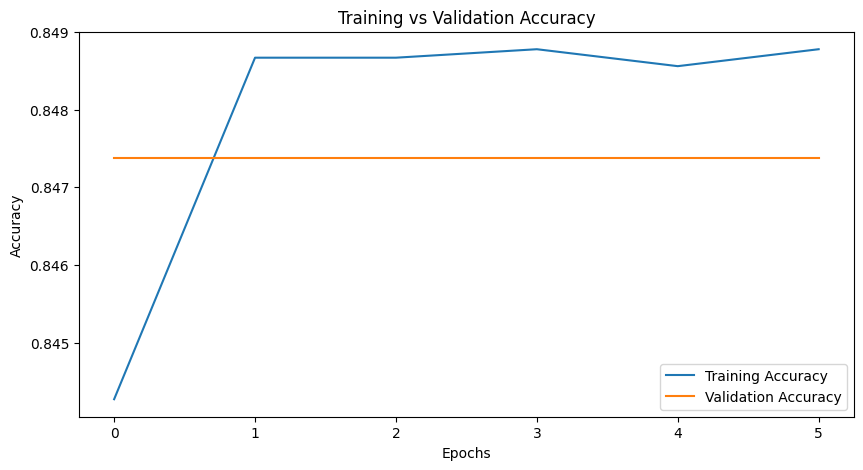

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history_early_stop.history['accuracy'], label='Training Accuracy')
plt.plot(history_early_stop.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
y_pred_ann_early = ann_model_early.predict(X_test_sc)

269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
y_pred_ann_early = (y_pred_ann_early > 0.5).astype(int)

In [ ]:
print("Classification Report (Early Stopping):", classification_report(y_test, y_pred_ann_early))

Classification Report (Early Stopping):               precision    recall  f1-score   support

       False       0.76      1.00      0.87      4207
        True       1.00      0.70      0.83      4392

    accuracy                           0.85      8599
   macro avg       0.88      0.85      0.85      8599
weighted avg       0.88      0.85      0.85      8599



***Demo***

In [117]:
X_demo = offers_df[['offered_amount', 'monthly_cost', 'number_of_terms',
                     'first_withdrawal_amount', 'credit_score']]
ss_demo = StandardScaler()
ss_demo.fit(X_demo)

StandardScaler()

In [118]:
def predict_offer(
    offered_amount,
    monthly_cost,
    number_of_terms,
    first_withdrawal_amount,
    credit_score
):

    if offered_amount <= 0:
        return {"error": "Offered amount must be > 0"}

    if monthly_cost <= 0:
        return {"error": "Monthly cost must be > 0"}

    if number_of_terms <= 0:
        return {"error": "Number of terms must be > 0"}

    if first_withdrawal_amount < 0:
        return {"error": "First withdrawal amount cannot be negative"}

    if first_withdrawal_amount > offered_amount:
        return {"error": "First withdrawal cannot exceed offered amount"}

    if credit_score < 0 or credit_score > 1145:
        return {"error": "Credit score must be between 0 and 1145"}

    X_new = np.array([
        offered_amount,
        monthly_cost,
        number_of_terms,
        first_withdrawal_amount,
        credit_score
    ]).reshape(1, -1)

    X_new_scaled = ss_demo.transform(X_new)

    prob_accept = xgb_pruned.predict_proba(X_new_scaled)[0, 1]

    decision = "Accepted" if prob_accept >= 0.5 else "Refused"

    return {
        "Decision": decision,
        "Probability_of_Acceptance": round(prob_accept, 3),
        "Risk_of_Rejection": round(1 - prob_accept, 3)
    }

In [119]:
inputs = [
    gr.Number(label="Offered Amount"),
    gr.Number(label="Monthly Cost"),
    gr.Number(label="Number of Terms"),
    gr.Number(label="First Withdrawal Amount"),
    gr.Number(label="Credit Score"),
]

app = gr.Interface(
    fn=predict_offer,
    inputs=inputs,
    outputs="json",
    title="Financial Offer Decision System",
    description="XGBoost model trained to predict client offer acceptance."
)

app.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c1fabe402dd44988e3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
